In [1]:
# use gpd_2023 environment

import pickle
import numpy as np
import pandas as pd
import torch    
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
# now get AUROC and average precision for the probas and mse for the ln's
from sklearn.metrics import roc_auc_score, average_precision_score, mean_squared_error, brier_score_loss

import sys
from pathlib import Path

# set path to the utils
PATH = Path("/home/simon/Documents/scripts/views_pipeline/models/purple_alien/notebooks/test_to_prediction_store.ipynb")
sys.path.insert(0, str(Path(*[i for i in PATH.parts[:PATH.parts.index("views_pipeline")+1]]) / "common_utils")) # PATH_COMMON_UTILS  
from set_path import setup_project_paths, setup_data_paths
setup_project_paths(PATH)

# now import the local functions
from utils_df_to_vol_conversion import df_to_vol, df_vol_conversion_test, plot_vol
from utils_wandb import generate_wandb_log_dict 
from utils_evaluation_metrics import EvaluationMetrics
from utils_model_outputs import ModelOutputs
from utils_hydranet_outputs import output_to_df, plot_metrics
from utils import get_full_tensor

# from somehwere imort get_full_tensor

# Functions 
We start with all well functioning well documented functions - note where the "live" and if anything needs to be adjusted for the if/when the function goes into a script.

You should move stuff to common_utils now if it is done... 


# Check that you volumn can be loaded and is correct..

Volume of shape (324, 180, 180, 8) created. Should be (n_months, 180, 180, 8)
Original DataFrame equals its copy: True
DataFrame of shape (4247640, 8) created. Should be (n_months * 180 * 180, 8)
Trimmed original DataFrame equals recreated DataFrame from volume: True


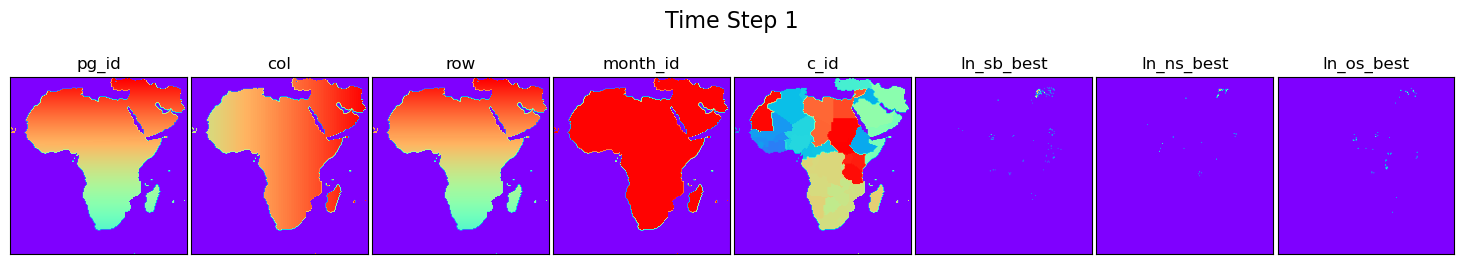

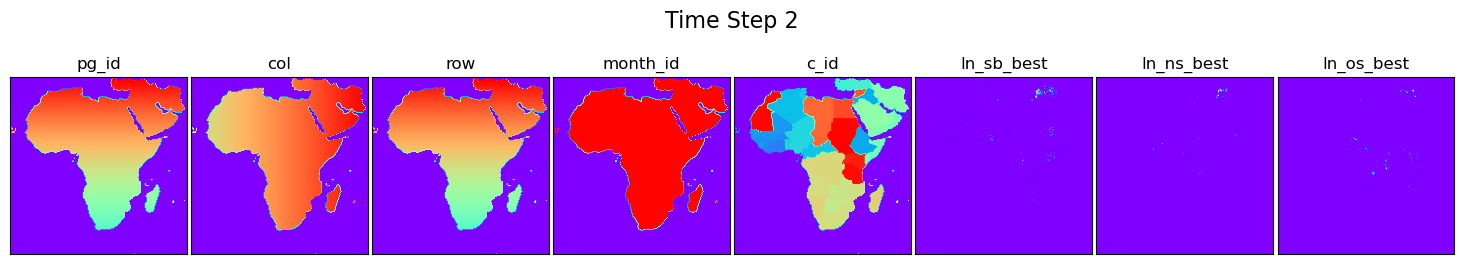

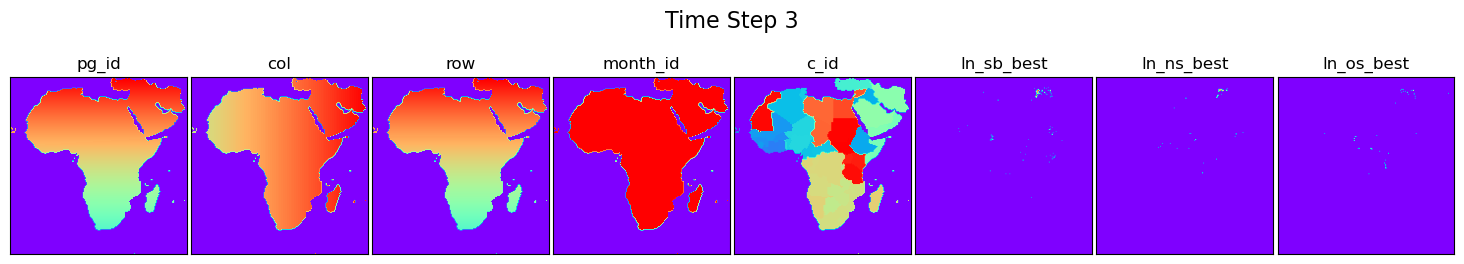

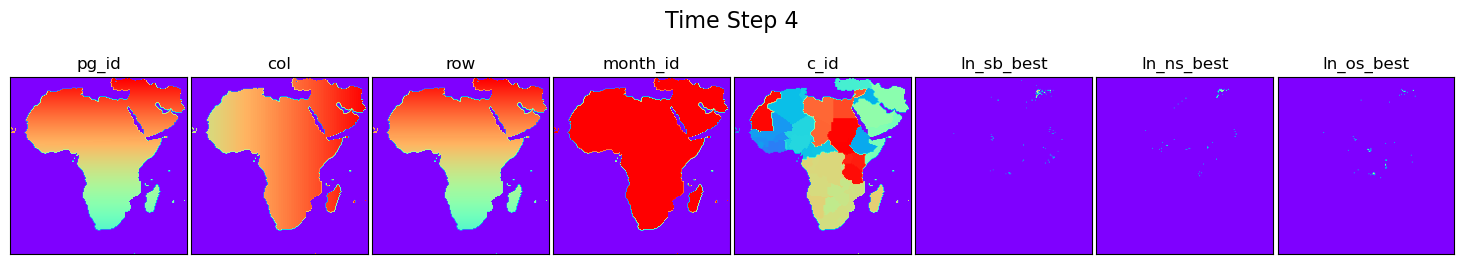

In [2]:
PATH_df = "/home/simon/Documents/scripts/views_pipeline/models/purple_alien/data/raw/calibration_viewser_df.pkl"

# get the df from the pickle file in raw_data
df = pd.read_pickle(PATH_df)

# turn the df1 into a volume
vol = df_to_vol(df)

df_vol_conversion_test(df, vol)

plot_vol(vol, 4)

In [3]:
# check unique values for the month_id in ]
np.unique(vol[:,:,:,3])

array([  0., 121., 122., 123., 124., 125., 126., 127., 128., 129., 130.,
       131., 132., 133., 134., 135., 136., 137., 138., 139., 140., 141.,
       142., 143., 144., 145., 146., 147., 148., 149., 150., 151., 152.,
       153., 154., 155., 156., 157., 158., 159., 160., 161., 162., 163.,
       164., 165., 166., 167., 168., 169., 170., 171., 172., 173., 174.,
       175., 176., 177., 178., 179., 180., 181., 182., 183., 184., 185.,
       186., 187., 188., 189., 190., 191., 192., 193., 194., 195., 196.,
       197., 198., 199., 200., 201., 202., 203., 204., 205., 206., 207.,
       208., 209., 210., 211., 212., 213., 214., 215., 216., 217., 218.,
       219., 220., 221., 222., 223., 224., 225., 226., 227., 228., 229.,
       230., 231., 232., 233., 234., 235., 236., 237., 238., 239., 240.,
       241., 242., 243., 244., 245., 246., 247., 248., 249., 250., 251.,
       252., 253., 254., 255., 256., 257., 258., 259., 260., 261., 262.,
       263., 264., 265., 266., 267., 268., 269., 27

In [4]:
df

,month_id,pg_id,month,year_id,c_id,col,row,ln_sb_best,ln_ns_best,ln_os_best,in_viewser,abs_row,abs_col,abs_month
1573200,121,62356,1,1990,192,436,87,0.0,0.0,0.0,True,0,126,0
1573201,121,79599,1,1990,192,399,111,0.0,0.0,0.0,True,24,89,0
1573202,121,79600,1,1990,192,400,111,0.0,0.0,0.0,True,24,90,0
1573203,121,79601,1,1990,192,401,111,0.0,0.0,0.0,True,24,91,0
1573204,121,80317,1,1990,192,397,112,0.0,0.0,0.0,True,25,87,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5820835,444,190496,12,2016,89,416,265,0.0,0.0,0.0,True,178,106,323
5820836,444,190507,12,2016,96,427,265,0.0,0.0,0.0,True,178,117,323
5820837,444,190508,12,2016,96,428,265,0.0,0.0,0.0,True,178,118,323
5820838,444,190510,12,2016,96,430,265,0.0,0.0,0.0,True,178,120,323


# Now...

# Then figure out the thing below with doing stuff without the ourput tensor... 

-----------------------------------------
# Stuff THAT WORKS!!!

Now it is basically about:
- take the bit loop below, and make sure it works for both eval and forecasing using the meta thing
- Also there should be a simple way to turn as out_put_dict into a metric dict... 
    - Can you think future output drift detection into this or is that completely seperate?
- Then package everything nice and neat
- Distribute to relevant/appropiate scripts
- Make sure to ubdate the eval rutine to corrospond
- Then implement the forecasting rutine... Finally. 


## old notes

## start reading here!!! :

This is the thing that need to be the fundament.
First I need to see that this works with the storage_array or another way of retaining or retreaving pg_id and month_id
One possible way to do this is by using the meta_tensor you have started on below
An alternative would be to to make a full full_tensor. I.e one that contains both the 3 prime feature and the "meta" fatures
Ones we have proven we can get month_id and pgm back we need to see a out-of-sampel solution where we go beyond what is in the df
And then I think we need to go back streamline the evaluation process so it follows. WHile doing so I must
    
- keep true forecasting firmly in the mind
- Think about what, if anything, can be abstracted out to common_utils for the sake of getting it right for the stepshifters - maybe wandb stuff
- And while ad it, make sure you use you new data class to store the monthly metrics -------------------------------------------------This now--------------------------
- The more you can absract out and make general, the simple it should be
- And while you add it, make sure to check if the partitions are the same as in paper. If they are, get the results down and finish paper.


# WHAT YOU ARE REALLY DOING:
- Aligning evaluation with forecasting to make a common appraoch
- MAke sure that logging and uploading (wandb) of metrics is consice and consitant
- Make sure that logging and uplaoding (predicion store and other?) os out outs from all partitions - whether true forecast or not - is consice and consistent
- You might want a data class thing of outputs (like the one uo have ofr metrics). Generel for all models forecsating conflict
- You want to make everythign as generel/abstract as possible - especially WandB stuff!!!

In [5]:
PATH_posterior_dict = "/home/simon/Documents/scripts/views_pipeline/models/purple_alien/data/generated/posterior_dict_36_calibration_20240613_165106.pkl"

# get the posterior_dict from the pickle file in generated
with open(PATH_posterior_dict, 'rb') as f:
    posterior_dict = pickle.load(f)

month_range = 36 # MAGIC NUMBER ALERT - this is the number of months in the future we are forecasting

# get the three lists from the posterior_dict - we make the out_of_sample_vol later
posterior_list, posterior_list_class, _ = posterior_dict['posterior_list'], posterior_dict['posterior_list_class'], posterior_dict['out_of_sample_vol'] # obviously there will be no out_of_sample_vol with true forecasting...

In [6]:
# get the views_vol from the df
views_vol = df_to_vol(df)
views_vol = views_vol.copy() # why the fuck face this works I swear I have no idea

# get the full_tensor and the new meta_data:tendor
full_tensor, metadata_tensor = get_full_tensor(views_vol ) #, config, device) # better cal this evel tensor
print(views_vol.shape)

# Get the out of sample vol and the out of sampele meta_vol <---------------------------- THIS IS CENTRAL, BECAUSE TO REAL FORECASTING TO WORK YOU JUST NEED TO GEN A SYNTH out_of_sample_meta_vol
out_of_sample_vol = full_tensor[:,-month_range:,:,:,:] #.cpu().numpy() # From the test tensor get the out-of-sample time_steps.
out_of_sample_meta_vol = metadata_tensor[:,-month_range:,:,:,:]

print(out_of_sample_vol.shape)
print(out_of_sample_meta_vol.shape)

# Merge full_tensor and metadata_tensor along the feature dimension - just a test
full_t_new = np.concatenate((out_of_sample_meta_vol, out_of_sample_vol), axis=2)

print(f'Shape of merged tensor: {full_t_new.shape}') # lets trust that 

Volume of shape (324, 180, 180, 8) created. Should be (n_months, 180, 180, 8)
views_vol shape (324, 180, 180, 8)
full_tensor shape torch.Size([1, 324, 3, 180, 180])
(324, 180, 180, 8)
torch.Size([1, 36, 3, 180, 180])
torch.Size([1, 36, 5, 180, 180])
Shape of merged tensor: (1, 36, 8, 180, 180)


In [7]:
steps = 36
eval = True

# bad name if eval is an arguement.... evaluate_andor_forecast_posterior

#def evaluate_posterior(model, views_vol, config, device): # is eval in config?

#posterior_list, posterior_list_class, out_of_sample_vol, full_tensor, metadata_tensor = sample_posterior(model, views_vol, config, device)


if eval:
    dict_of_eval_dicts = {}
    dict_of_eval_dicts = {k: EvaluationMetrics.make_evaluation_dict(steps=steps) for k in ["sb", "ns", "os"]}

dict_of_outputs_dicts = {}
dict_of_outputs_dicts = {k: ModelOutputs.make_output_dict(steps=steps) for k in ["sb", "ns", "os"]}

# Get mean and std
mean_array = np.array(posterior_list).mean(axis = 0) # get mean for each month!
std_array = np.array(posterior_list).std(axis = 0)

mean_class_array = np.array(posterior_list_class).mean(axis = 0) # get mean for each month!
std_class_array = np.array(posterior_list_class).std(axis = 0)

#NEW
log_dict_list = []
#feature_dict_list = []

for t in range(mean_array.shape[0]): #  0 of mean array is the temporal dim    
    
    log_dict = {}
    log_dict["monthly/out_sample_month"] = t +1 # 1 indexed, bc the first step is 1 month ahead

    for i, j in enumerate(dict_of_eval_dicts.keys()): # this is the same as the above but with the dict keys

        step = f"step{str(t+1).zfill(2)}"
        
        # get the scores
        y_score = mean_array[t,i,:,:].reshape(-1) # make it 1d  # nu 180x180 
        y_score_prob = mean_class_array[t,i,:,:].reshape(-1) # nu 180x180 
        
        # do not really know what to do with these yet.
        y_var = std_array[t,i,:,:].reshape(-1)  # nu 180x180  
        y_var_prob = std_class_array[t,i,:,:].reshape(-1)  # nu 180x180 

        # see this is the out of sample vol - fine for evaluation but not for forecasting
        # but also the place where you get the pgm.. 

        if eval:
            y_true = out_of_sample_vol[:,t,i,:,:].numpy().reshape(-1)  # nu 180x180 . dim 0 is time     THE TRICK IS NOW TO USE A df -> vol and not out_of_sample_vol...
            y_true_binary = (y_true > 0) * 1

            # in theorty you could just use the metadata tensor to get pg and c id here
            pg_id = out_of_sample_meta_vol[:,t,0,:,:].numpy().reshape(-1)  # nu 180x180, dim 1 is time . dim 2 is feature. feature 0 is pg_id
            c_id = out_of_sample_meta_vol[:,t,4,:,:].numpy().reshape(-1)  # nu 180x180, dim 1 is time . dim 2 is feature. feature 4 is c_id
            month_id = out_of_sample_meta_vol[:,t,3,:,:].numpy().reshape(-1)  # nu 180x180, dim 1 is time . dim 2 is feature. feature 3 is month_id

            dict_of_outputs_dicts[j][step].y_true = y_true
            dict_of_outputs_dicts[j][step].y_true_binary = y_true_binary

        else: # you need to make sure this works for forecasting
            # in theorty you could just use the metadata tensor to get pg and c id here
            pg_id = out_of_sample_meta_vol[:,t,0,:,:].numpy().reshape(-1)  # nu 180x180, dim 1 is time . dim 2 is feature. feature 0 is pg_id
            c_id = out_of_sample_meta_vol[:,t,4,:,:].numpy().reshape(-1)  # nu 180x180, dim 1 is time . dim 2 is feature. feature 4 is c_id
            month_id = out_of_sample_meta_vol[:,t,3,:,:].numpy().reshape(-1)  # nu 180x180, dim 1 is time . dim 2 is feature. feature 3 is month_id


        dict_of_outputs_dicts[j][step].y_score = y_score
        dict_of_outputs_dicts[j][step].y_score_prob = y_score_prob
        dict_of_outputs_dicts[j][step].y_var = y_var
        dict_of_outputs_dicts[j][step].y_var_prob = y_var_prob

        dict_of_outputs_dicts[j][step].pg_id = pg_id # in theory this should be in the right order
        dict_of_outputs_dicts[j][step].c_id = c_id # in theory this should be in the right order
        dict_of_outputs_dicts[j][step].step = t +1 # 1 indexed, bc the first step is 1 month ahead
        dict_of_outputs_dicts[j][step].month_id = month_id

        if eval:   

            dict_of_eval_dicts[j][step].MSE = mean_squared_error(y_true, y_score)
            dict_of_eval_dicts[j][step].AP = average_precision_score(y_true_binary, y_score_prob)
            dict_of_eval_dicts[j][step].AUC = roc_auc_score(y_true_binary, y_score_prob)
            dict_of_eval_dicts[j][step].Brier = brier_score_loss(y_true_binary, y_score_prob)

            log_dict = generate_wandb_log_dict(log_dict, dict_of_eval_dicts, j, step)

    if eval:
        log_dict_list.append(log_dict)
        #wandb.log(log_dict)
    
    if not config.sweep:
            
        _ , _, PATH_GENERATED = setup_data_paths(PATH)

        # if the path does not exist, create it - maybe doable with Pathlib, but this is a well recognized way of doing it.
        #if not os.path.exists(PATH_GENERATED):
        #    os.makedirs(PATH_GENERATED)

        # Pathlib alternative 
        Path(PATH_GENERATED).mkdir(parents=True, exist_ok=True)

        # print for debugging
        print(f'PATH to generated data: {PATH_GENERATED}')

        # pickle the posterior dict, metric dict, and test vol
        # Should be time_steps and run_type in the name....

        posterior_dict = {'posterior_list' : posterior_list, 'posterior_list_class': posterior_list_class, 'out_of_sample_vol' : out_of_sample_vol}

        #metric_dict = {'out_sample_month_list' : out_sample_month_list, 'mse_list': mse_list,
        #                'ap_list' : ap_list, 'auc_list': auc_list, 'brier_list' : brier_list}

        df_full = output_to_df(dict_of_outputs_dicts)


        # Note: we are using the model_time_stamp from the model artifact to denote the time stamp for the pkl files
        # This is to ensure that the pkl files are easily identifiable and associated with the correct model artifact
        # But it also means that running evaluation on the same model artifact multiple times will overwrite the pkl files
        # I think this is fine, but we should think about cases where we might want to evaluate the same model artifact multiple times - maybe for robustiness checks or something for publication. 

        with open(f'{PATH_GENERATED}/posterior_dict_{config.time_steps}_{config.run_type}_{config.model_time_stamp}.pkl', 'wb') as file:
            pickle.dump(posterior_dict, file)       

        #with open(f'{PATH_GENERATED}/metric_dict_{config.time_steps}_{config.run_type}_{config.model_time_stamp}.pkl', 'wb') as file:
        #    pickle.dump(metric_dict, file)

        with open(f'{PATH_GENERATED}/df_full_{config.time_steps}_{config.run_type}_{config.model_time_stamp}.pkl', 'wb') as file: # make it numpy
            pickle.dump(df_full, file)

        with open(f'{PATH_GENERATED}/test_vol_{config.time_steps}_{config.run_type}_{config.model_time_stamp}.pkl', 'wb') as file: # make it numpy
            pickle.dump(full_tensor.cpu().numpy(), file)

        with open(f'{PATH_GENERATED}/metadata_vol_{config.time_steps}_{config.run_type}_{config.model_time_stamp}.pkl', 'wb') as file:
            pickle.dump(metadata_tensor.cpu().numpy(), file)

        print('Posterior dict, metric dict and test vol pickled and dumped!')

    else:
        print('Running sweep. NO posterior dict, metric dict, or test vol pickled+dumped')

    #log_wandb_mean_metrics(config, mse_list, ap_list, auc_list, brier_list) # correct and reimplment this



In [8]:
df_full = output_to_df(dict_of_outputs_dicts)

In [9]:
print(average_precision_score(df_full["y_true_binary_sb"], df_full["y_score_prob_sb"]))
print(average_precision_score(df_full["y_true_binary_ns"], df_full["y_score_prob_ns"]))
print(average_precision_score(df_full["y_true_binary_os"], df_full["y_score_prob_os"]))

0.4866353087912502
0.16918413433592092
0.20340239206107322


In [27]:
df_eval = EvaluationMetrics.evaluation_dict_to_dataframe(dict_of_evel_dicts['sb'])

In [28]:
df_eval

,MSE,MAE,MSLE,KLD,Jeffreys,CRPS,Brier,AP,AUC,ensemble_weight_reg,ensemble_weight_class
step01,0.002375,None,None,None,None,None,0.003328,0.535926,0.983830,None,None
step02,0.002214,None,None,None,None,None,0.003261,0.549718,0.983092,None,None
step03,0.002995,None,None,None,None,None,0.003351,0.566352,0.986172,None,None
step04,0.003177,None,None,None,None,None,0.003261,0.576629,0.985225,None,None
step05,0.003179,None,None,None,None,None,0.003403,0.520288,0.986079,None,None
step06,0.003758,None,None,None,None,None,0.003473,0.560815,0.990995,None,None
step07,0.006062,None,None,None,None,None,0.003377,0.589042,0.986978,None,None
step08,0.005370,None,None,None,None,None,0.003391,0.556503,0.987486,None,None
step09,0.004595,None,None,None,None,None,0.003425,0.549882,0.992166,None,None
step10,0.003809,None,None,None,None,None,0.003553,0.535586,0.988216,None,None


In [21]:
df_full

,y_score_sb,y_score_prob_sb,y_var_sb,y_var_prob_sb,y_true_sb,y_true_binary_sb,y_score_ns,y_score_prob_ns,y_var_ns,y_var_prob_ns,...,y_score_prob_os,y_var_os,y_var_prob_os,y_true_os,y_true_binary_os,pg_id,c_id,month_id,step,month
0,0.0,0.013558,0.0,0.008179,0.0,0,0.0,0.004687,0.0,0.002895,...,0.010500,0.0,0.006189,0.0,0,190494.0,89.0,409,1,1
1,0.0,0.020356,0.0,0.009871,0.0,0,0.0,0.006022,0.0,0.003209,...,0.012333,0.0,0.006095,0.0,0,190495.0,89.0,409,1,1
2,0.0,0.027460,0.0,0.012424,0.0,0,0.0,0.008364,0.0,0.004144,...,0.019508,0.0,0.009321,0.0,0,190496.0,89.0,409,1,1
3,0.0,0.009538,0.0,0.007211,0.0,0,0.0,0.003074,0.0,0.002566,...,0.006503,0.0,0.004539,0.0,0,190507.0,96.0,409,1,1
4,0.0,0.006481,0.0,0.004125,0.0,0,0.0,0.002569,0.0,0.001581,...,0.006217,0.0,0.003528,0.0,0,190508.0,96.0,409,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471955,0.0,0.003614,0.0,0.004323,0.0,0,0.0,0.001503,0.0,0.001383,...,0.002464,0.0,0.001887,0.0,0,80332.0,163.0,444,36,36
471956,0.0,0.008943,0.0,0.011926,0.0,0,0.0,0.002032,0.0,0.002195,...,0.002838,0.0,0.002421,0.0,0,79599.0,163.0,444,36,36
471957,0.0,0.006220,0.0,0.005659,0.0,0,0.0,0.001627,0.0,0.001113,...,0.004396,0.0,0.004370,0.0,0,79600.0,163.0,444,36,36
471958,0.0,0.009132,0.0,0.007041,0.0,0,0.0,0.001990,0.0,0.001772,...,0.002452,0.0,0.002741,0.0,0,79601.0,163.0,444,36,36


In [24]:
df_full[['y_score_sb', 'pg_id', 'month_id']]# ln(sb fatalities + 1)

,y_score_sb,pg_id,month_id
0,0.0,190494.0,409
1,0.0,190495.0,409
2,0.0,190496.0,409
3,0.0,190507.0,409
4,0.0,190508.0,409
...,...,...,...
471955,0.0,80332.0,444
471956,0.0,79599.0,444
471957,0.0,79600.0,444
471958,0.0,79601.0,444


In [22]:
np.unique(df_full[['y_true_sb']]) # proba of sb fatalities

array([0.        , 0.69314718, 1.09861231, 1.38629436, 1.60943794,
       1.79175949, 1.9459101 , 2.07944155, 2.19722462, 2.30258512,
       2.39789534, 2.48490667, 2.56494927, 2.6390574 , 2.70805025,
       2.77258873, 2.83321333, 2.8903718 , 2.94443893, 2.99573231,
       3.04452252, 3.09104252, 3.13549423, 3.17805386, 3.21887589,
       3.25809646, 3.29583693, 3.33220458, 3.36729574, 3.40119743,
       3.43398714, 3.46573591, 3.49650764, 3.52636051, 3.55534816,
       3.58351898, 3.61091781, 3.63758612, 3.66356158, 3.68887949,
       3.71357203, 3.73766971, 3.76120019, 3.7841897 , 3.80666256,
       3.82864141, 3.85014749, 3.87120104, 3.89182019, 3.91202307,
       3.93182564, 3.95124364, 3.97029185, 3.98898411, 4.00733328,
       4.04305124, 4.06044292, 4.07753754, 4.09434462, 4.1108737 ,
       4.12713432, 4.14313459, 4.15888309, 4.17438745, 4.18965483,
       4.20469284, 4.23410654, 4.2484951 , 4.26268005, 4.27666616,
       4.29045963, 4.30406523, 4.31748819, 4.34380531, 4.35670

In [ ]:
np.exp()

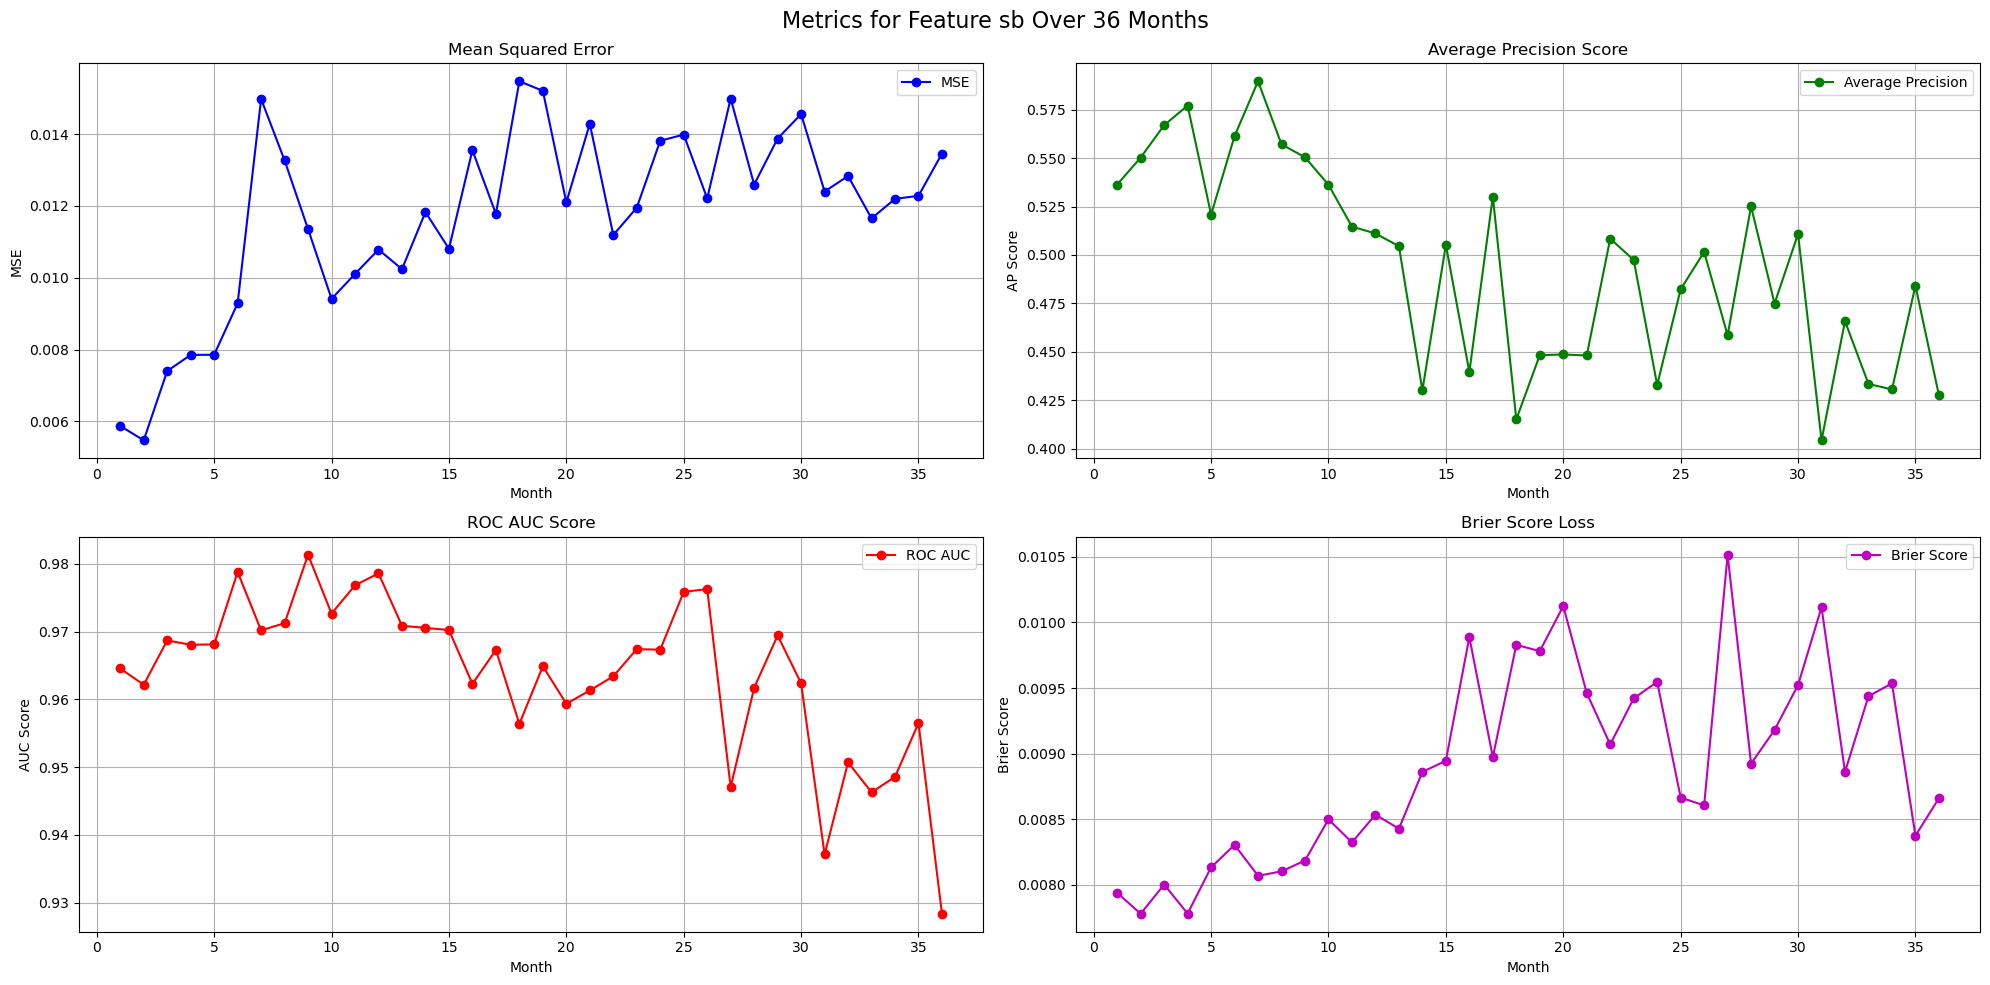

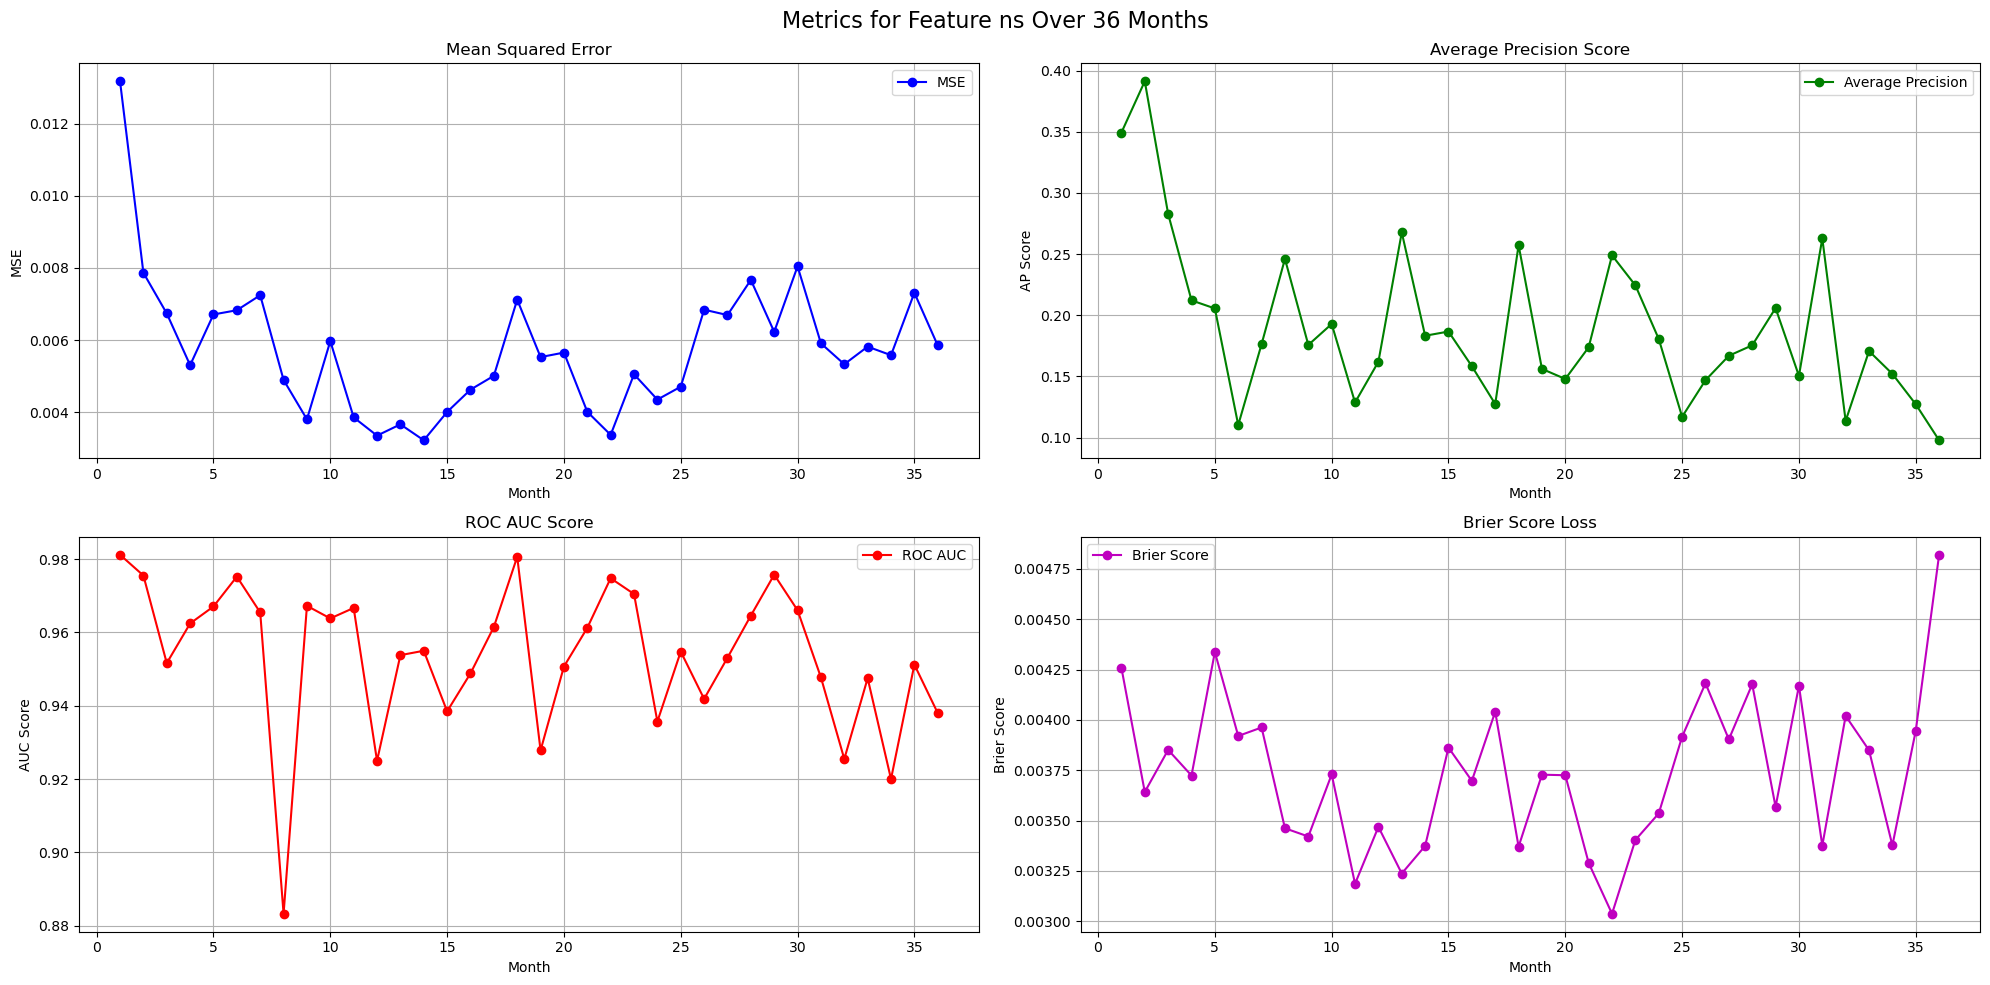

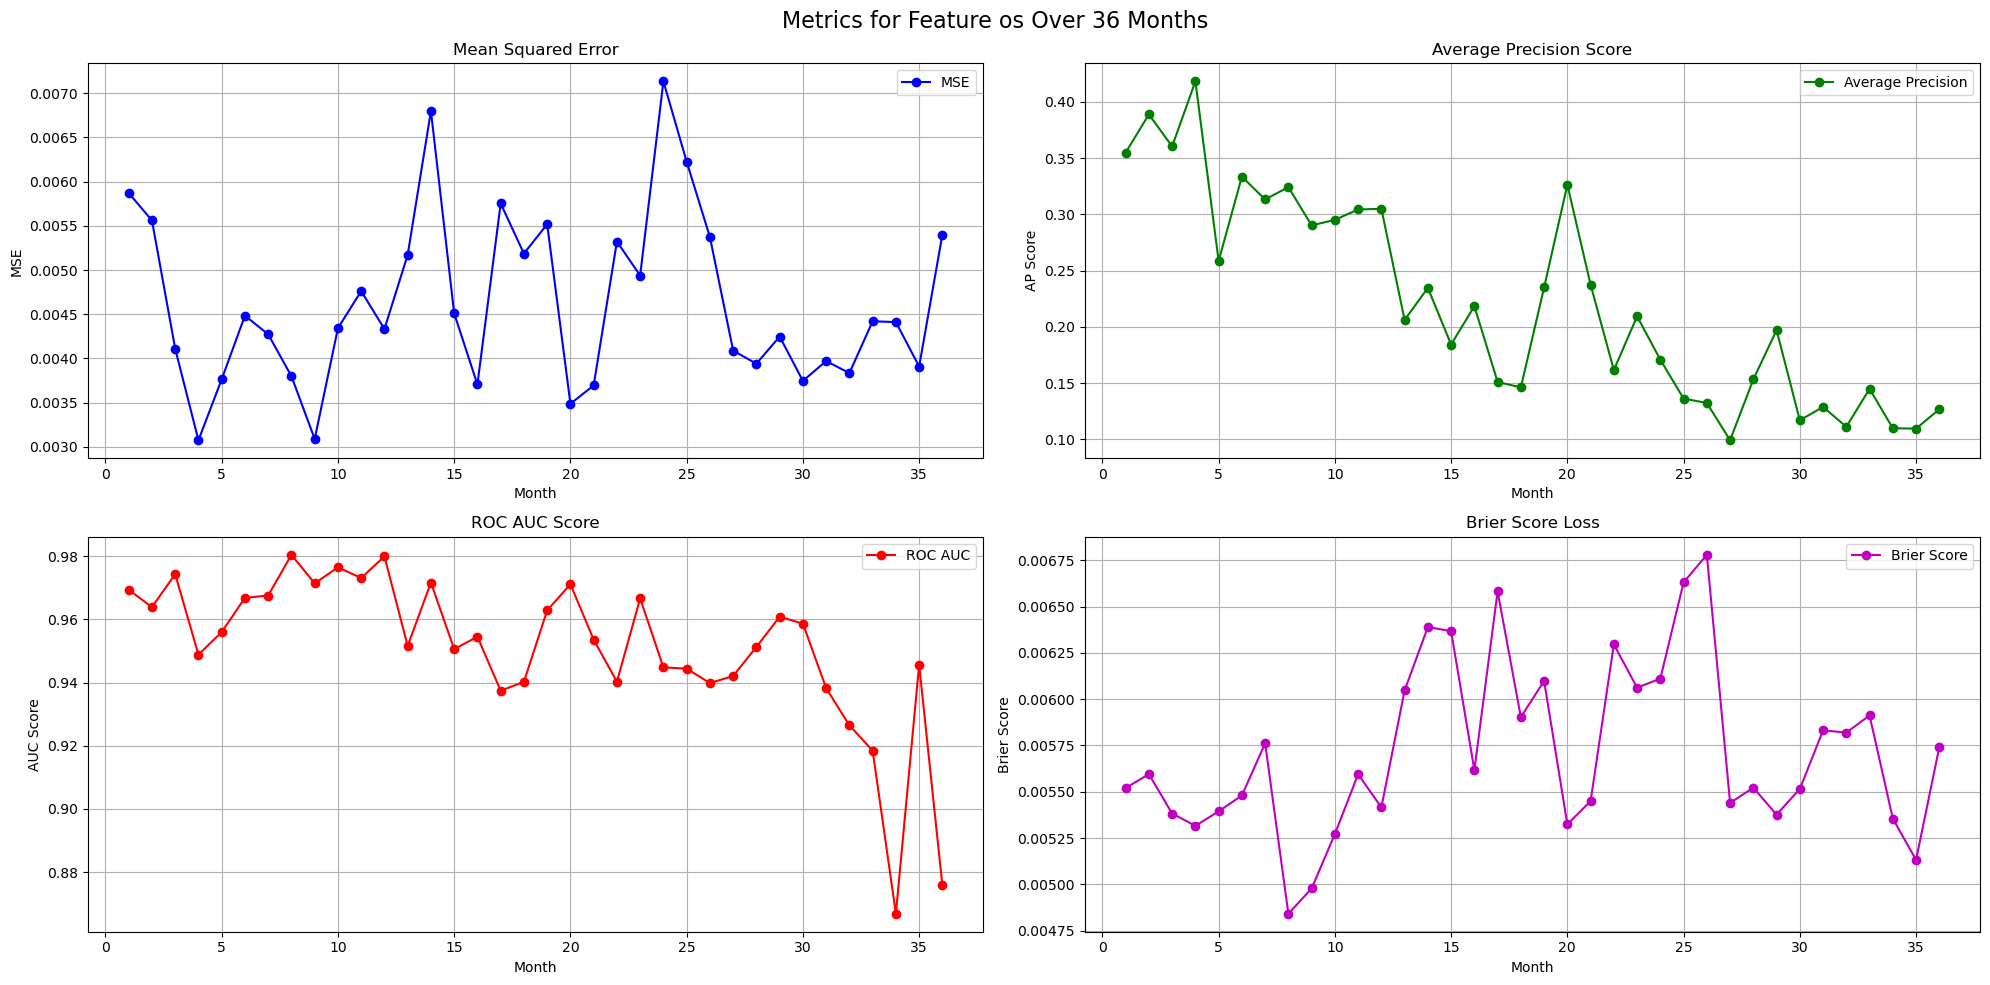

In [10]:
# Example usage:
plot_metrics(df_full, "sb")

# Example usage:
plot_metrics(df_full, "ns")

# Example usage:
plot_metrics(df_full, "os")

# OLD but GOLD

In [ ]:
#df_test2 = pd.DataFrame.from_dict(feature_dict_list_2).apply(pd.Series.explode)

In [ ]:
feature_dict_list

In [ ]:
df_test2 = pd.DataFrame.from_dict(feature_dict_list).apply(pd.Series.explode)

#df_test2 = df_test4

# reset the index and keep the old index as a column month
df_test2 = df_test2.reset_index().rename(columns = {"index": "month"})

df_test2 # we don't konw if the month order is correct yet... But I highly suspect that it is.

# check all datatyps in columns
df_test2.dtypes

# change all columns to float
df_test2 = df_test2.astype(float)

# check all datatyps in columns
df_test2.dtypes

# make the binary columns integers
df_test2 = df_test2.astype({"y_true_binary0": int, "y_true_binary1": int, "y_true_binary2": int})

# check all datatyps in columns
df_test2.dtypes

In [ ]:
print(average_precision_score(df_test2["y_true_binary0"], df_test2["y_score_prob0"]))
print(average_precision_score(df_test2["y_true_binary1"], df_test2["y_score_prob1"]))
print(average_precision_score(df_test2["y_true_binary2"], df_test2["y_score_prob2"]))

In [ ]:
# Example usage:
plot_metrics(df_test2, 0)

# Example usage:
plot_metrics(df_test2, 1)

# Example usage:
plot_metrics(df_test2, 2)


# OLD BUT USEFUL CODE BELOW

# Test: Df to vol, vol to df

Lest check that we can load the df, create a volumn, and then recreate af df again

### Functions

In [ ]:
#def df_to_vol(df):
#    """
#    Converts a DataFrame into a 4D volume array for spatial-temporal data representation.
#    The volume array is [height, width, n_months, n_features].
#
#    Args:
#        df (pd.DataFrame): The input DataFrame containing spatial-temporal data with columns
#                           'abs_row', 'abs_col', 'abs_month', 'pg_id', 'col', 'row',
#                           'month_id', 'c_id', 'ln_sb_best', 'ln_ns_best', and 'ln_os_best'.
#
#    Returns:
#        np.ndarray: The volume representation of the DataFrame with shape 
#                    [n_months, height, width, n_features].
#                    The specific shape will be [n_months, 180, 180, 8].
#    """
#    month_first = df['month_id'].min()
#    month_last = df['month_id'].max()
#    month_range = month_last - month_first + 1
#    space_range = 180
#    features_num = 8  # Should match the number of features in the DataFrame
#
#    vol = np.zeros([space_range, space_range, month_range, features_num])
#
#    vol[df['abs_row'], df['abs_col'], df['abs_month'], 0] = df['pg_id']
#    vol[df['abs_row'], df['abs_col'], df['abs_month'], 1] = df['col']
#    vol[df['abs_row'], df['abs_col'], df['abs_month'], 2] = df['row']
#    vol[df['abs_row'], df['abs_col'], df['abs_month'], 3] = df['month_id']
#    vol[df['abs_row'], df['abs_col'], df['abs_month'], 4] = df['c_id']
#    vol[df['abs_row'], df['abs_col'], df['abs_month'], 5] = df['ln_sb_best']
#    vol[df['abs_row'], df['abs_col'], df['abs_month'], 6] = df['ln_ns_best']
#    vol[df['abs_row'], df['abs_col'], df['abs_month'], 7] = df['ln_os_best']
#
#    vol = np.flip(vol, axis=0)  # Flip the rows, so north is up.
#    vol = np.transpose(vol, (2, 0, 1, 3))  # Move the month dimension to the front.
#
#    print(f'Volume of shape {vol.shape} created. Should be (n_months, 180, 180, 8)')
#
#    return vol
#

In [ ]:
def vol_to_df(vol):
    """
    Converts a 4D volume array back into a DataFrame for spatial-temporal data.
    The volume array is expected to have dimensions [n_months, height, width, n_features].

    Args:
        vol (np.ndarray): The input 4D volume array to be converted, with shape 
                          [n_months, height, width, n_features].

    Returns:
        pd.DataFrame: The DataFrame representation of the volume array containing columns
                      'pg_id', 'col', 'row', 'month_id', 'c_id', 'ln_sb_best', 'ln_ns_best', 'ln_os_best'.
                      DataFrame is cleaned to remove rows where 'pg_id' is 0.
    """
    n_months, height, width, n_features = vol.shape

    df = pd.DataFrame({
        'pg_id': vol[:, :, :, 0].flatten(),
        'col': vol[:, :, :, 1].flatten(),
        'row': vol[:, :, :, 2].flatten(),
        'month_id': vol[:, :, :, 3].flatten(),
        'c_id': vol[:, :, :, 4].flatten(),
        'ln_sb_best': vol[:, :, :, 5].flatten(),
        'ln_ns_best': vol[:, :, :, 6].flatten(),
        'ln_os_best': vol[:, :, :, 7].flatten()
    })

    # Correct the data types
    df['pg_id'] = df['pg_id'].astype(int)
    df['col'] = df['col'].astype(int)
    df['row'] = df['row'].astype(int)
    df['month_id'] = df['month_id'].astype(int)
    df['c_id'] = df['c_id'].astype(int)

    # Remove rows where 'pg_id' is 0
    df = df[df['pg_id'] != 0]

    print(f'DataFrame of shape {df.shape} created. Should be (n_months * 180 * 180, 8)')

    return df


In [ ]:
def df_vol_test(df, vol):
    """
    Unit test to verify the conversion between DataFrame and volume array.
    Checks if the original DataFrame and the DataFrame created from the volume are equivalent.

    Args:
        df (pd.DataFrame): The original DataFrame.
        vol (np.ndarray): The 4D volume array created from the DataFrame.

    Returns:
        None: Prints the result of the equivalence test.
    """
    # Make a copy of the original DataFrame
    df_copy = df.copy()

    # Proof of concept: Check if the copy is the same as the original
    print("Original DataFrame equals its copy:", df.equals(df_copy))

    # Convert the volume back into a DataFrame
    df_recreated = vol_to_df(vol)

    # Trim the original DataFrame to match the features of the recreated DataFrame
    df_trimmed = df[['pg_id', 'col', 'row', 'month_id', 'c_id', 'ln_sb_best', 'ln_ns_best', 'ln_os_best']]

    # Sort both DataFrames by 'pg_id' and 'month_id'
    df_trimmed = df_trimmed.sort_values(by=['pg_id', 'month_id'])
    df_recreated = df_recreated.sort_values(by=['pg_id', 'month_id'])

    # Reset the index to ensure alignment
    df_trimmed = df_trimmed.reset_index(drop=True)
    df_recreated = df_recreated.reset_index(drop=True)

    # Check if the two DataFrames are the same
    is_equal = df_trimmed.equals(df_recreated)
    print("Trimmed original DataFrame equals recreated DataFrame from volume:", is_equal)


In [ ]:
def plot_vol(vol, month_range):
    """
    Plots slices of the 4D volume array for the specified month range.
    Displays different feature maps for each time step in separate subplots.

    Args:
        vol (np.ndarray): The input 4D volume array with shape [n_months, height, width, n_features].
        month_range (int): The number of slices (time steps) to plot.

    Returns:
        None: Displays the plots.
    """
    features_titles = ['pg_id', 'col', 'row', 'month_id', 'c_id', 'ln_sb_best', 'ln_ns_best', 'ln_os_best']
    n_features = vol.shape[-1]

    # get sub_df of the lasst month_range months
    vol = vol[-month_range:, :, :, :]

    for i in range(month_range):
        fig, ax = plt.subplots(1, n_features, figsize=(20, 4))
        
        for j in range(min(n_features, vol.shape[-1])):  # Handle cases where there are fewer than 7 features
            im = ax[j].imshow(vol[i, :, :, j], cmap='rainbow', vmin= vol[:, :, :, j].min(), vmax= vol[:, :, :, j].max())
            ax[j].set_title(features_titles[j] if j < len(features_titles) else f'Feature {j}')
            # plt.colorbar(im, ax=ax[j])

        # Adding title with specific adjustment
        fig.suptitle(f'Time Step {i + 1}', fontsize=16, y=1.05)  # Adjust `y` for title position

        # remove ticks
        for a in ax:
            a.set_xticks([])
            a.set_yticks([])

        # Adjust layout
        plt.subplots_adjust(left=0.1, right=1, top=0.85, bottom=0.55, wspace=0.2, hspace=-0)
        plt.tight_layout(pad=2.0, rect=[0, 0, 1, 0.9])  # `rect` adjusts the position of subplots
        
        plt.show()


### Execute


In [ ]:
# set the path to the raw data
PATH = "/home/simon/Documents/scripts/views_pipeline/models/purple_alien/data/raw/calibration_viewser_df.pkl"

# get the df from the pickle file in raw_data
df = pd.read_pickle(PATH)

# turn the df1 into a volume
vol = df_to_vol(df)

df_vol_test(df, vol)

plot_vol(vol, 4)

# forecast storage test
Now we test how we can make a storage array for the 4D forcast

### Functions

In [ ]:
def generate_fake_vol(vol, month_range=36):
    """
    Generates a fake prediction volume for testing purposes by extracting the last three features from the input volume.
    Assumes the last three features represent `sb`, `ns`, and `os`.

    Args:
        vol (np.ndarray): The input 4D volume array with shape [n_months, height, width, n_features].
        n_months (int): The number of months to include in the fake volume. Default is 36.

    Returns:
        np.ndarray: A volume array with the last three features, shape [32, height, width, 3].
                    Represents a subset of the original volume for testing.
    """
    # Extract the last three features from the volume
    fake_vol = vol[-month_range:, :, :, 5:]  

    return fake_vol


In [ ]:
def make_forecast_storage_vol(df, month_range = 36, true_forecast = False):
    """
    Creates a forecast storage volume based on the last month of data in the DataFrame.
    The volume is repeated for the specified `month_range` with incrementally adjusted month IDs.

    Args:
        df (pd.DataFrame): The input DataFrame containing spatial-temporal data.
                           Expected columns include 'abs_row', 'abs_col', 'abs_month', 'pg_id', 'col', 
                           'row', 'month_id', 'c_id'.
        month_range (int): The number of months to forecast into the future. Default is 36.

    Returns:
        np.ndarray: The forecast storage volume with shape [month_range, 180, 180, 5].
                    Each time slice in the volume represents a future month based on the last month of data.
    """
    # Infer the last month_id from the DataFrame
    last_month_id = df['month_id'].max()

    # Create a sub DataFrame of only the last month
    sub_df = df[df['month_id'] == last_month_id].copy()

    # Initialize the volume array
    space_range = 180
    features_num = 5  # Adjust this based on the number of features you have

    # Create the zero array with only the last month
    vol = np.zeros([space_range, space_range, 1, features_num])

    # Adjust abs_month to 0 for the initial volume
    sub_df['adjusted_abs_month'] = 0

    # Populate the volume array with the data from the DataFrame
    vol[sub_df['abs_row'], sub_df['abs_col'], sub_df['adjusted_abs_month'], 0] = sub_df['pg_id']
    vol[sub_df['abs_row'], sub_df['abs_col'], sub_df['adjusted_abs_month'], 1] = sub_df['col']
    vol[sub_df['abs_row'], sub_df['abs_col'], sub_df['adjusted_abs_month'], 2] = sub_df['row']
    vol[sub_df['abs_row'], sub_df['abs_col'], sub_df['adjusted_abs_month'], 3] = sub_df['month_id'] 
    vol[sub_df['abs_row'], sub_df['abs_col'], sub_df['adjusted_abs_month'], 4] = sub_df['c_id']

    # Stack the volume to the desired month range
    vol = np.repeat(vol, month_range, axis=2)

#    if true_forecast:
    # Adjust the month_id with an increment of 1
 #       for i in range(month_range):
            #vol[:, :, i, 3] = last_month_id + i + 1 # to get one month after the last observed month

#    else:
#        pass


    # THIS IS A WIERD THING AND THERE COULD BE A BUG HERE.... :
    # Adjust the month_id with an increment of 1
    for i in range(month_range):
        vol[:, :, i, 3] = last_month_id + i + 1 # to get one month after the last observed month

    # Reorient and transpose
    vol = np.flip(vol, axis=0)
    vol = np.transpose(vol, (2, 0, 1, 3))

    print(f'Volume of shape {vol.shape} created. Should be ({month_range}, 180, 180, {features_num})')

    return vol

In [ ]:
def merge_vol(forecast_storage_vol, vol_fake):
    """
    Merges a forecast volume with an existing forecast storage volume.
    Combines the features from `vol_fake` with `vol` along the feature axis.

    Args:
        vol (np.ndarray): The forecast storage volume with shape [n_months, height, width, n_features].
        vol_fake (np.ndarray): The forecast volume to be merged with shape [n_months, height, width, n_features_fake].

    Returns:
        np.ndarray: The merged volume with shape [n_months, height, width, n_features + n_features_fake].
    """
    # Merge the forecast volume with the storage volume along the feature axis
    full_vol = np.concatenate([forecast_storage_vol, vol_fake], axis=-1)

    # print the shape of the full volume
    print(f'Volume of shape {full_vol.shape} created. Should be ({forecast_storage_vol.shape[0]}, 180, 180, {forecast_storage_vol.shape[3] + vol_fake.shape[3]})')

    return full_vol


In [ ]:
def check_vol_equal(vol, full_vol):
    """
    Unit test to verify the merging of two volumes.
    Checks if the original volume and the merged volume are equivalent.

    Args:
        vol (np.ndarray): The original volume.
        full_vol (np.ndarray): The merged volume.

    Returns:
        None: Prints the result of the equivalence test.
    """

    #print the shape of the volumes
    print(vol.shape)
    print(full_vol.shape)

    # trim original volume to the same shape as the full volume - ie. the last n months
    month_range = full_vol.shape[0]
    vol_trimmed = vol[-month_range:, :, :, :]

    # print the shape of the trimmed volume
    print(vol_trimmed.shape)

    # now go through each feature individually and check if they are the same

    list_features = ['pg_id', 'col', 'row', 'month_id', 'c_id', 'ln_sb_best', 'ln_ns_best', 'ln_os_best']

    for i in range(vol_trimmed.shape[-1]):
        print(f"Feature {i}, {list_features[i]} equal:", np.array_equal(vol_trimmed[:, :, :, i], full_vol[:, :, :, i]))


In [ ]:
def plot_vol_comparison(vol, new_vol, month_range=36):
    """
    Plots a comparison of slices from two 4D volume arrays for the specified month range.
    Displays different feature maps for each time step in separate subplots for both volumes.

    Args:
        vol (np.ndarray): The original 4D volume array with shape [n_months, height, width, n_features].
        new_vol (np.ndarray): The new 4D volume array to compare with, with the same shape as `vol`.
        month_range (int): The number of slices (time steps) to plot. Default is 36.

    Returns:
        None: Displays the plots.
    """
    features_titles = ['pg_id', 'col', 'row', 'month_id', 'c_id', 'ln_sb_best', 'ln_ns_best', 'ln_os_best']
    n_features = vol.shape[-1]

    # Ensure the volumes cover the last month_range months
    vol = vol[-month_range:, :, :, :]
    new_vol = new_vol[-month_range:, :, :, :]

    for i in range(month_range):
        fig, ax = plt.subplots(2, n_features, figsize=(20, 7))  # 2 rows, n_features columns
        
        for j in range(n_features):  # Adjusted to use n_features directly
            # Plot the original volume in the first row
            im1 = ax[0, j].imshow(vol[i, :, :, j], cmap='rainbow',
                                  vmin=vol[:, :, :, j].min(), vmax=vol[:, :, :, j].max())
            ax[0, j].set_title(features_titles[j] if j < len(features_titles) else f'Feature {j}')
            #plt.colorbar(im1, ax=ax[0, j])

            # Plot the new volume in the second row
            im2 = ax[1, j].imshow(new_vol[i, :, :, j], cmap='rainbow',
                                  vmin=new_vol[:, :, :, j].min(), vmax=new_vol[:, :, :, j].max())
            ax[1, j].set_title(f'New {features_titles[j]}' if j < len(features_titles) else f'New Feature {j}')
            #plt.colorbar(im2, ax=ax[1, j])

        # Adding title with specific adjustment
        fig.suptitle(f'Time Step {i + 1}', fontsize=16, y=1.05)  # Adjust `y` for title position

        # Remove ticks
        for a in ax.flat:
            a.set_xticks([])
            a.set_yticks([])

        # Adjust layout
        plt.subplots_adjust(left=0.05, right=0.95, top=0.85, bottom=0.15, wspace=0.2, hspace=0.4)
        plt.tight_layout(pad=2.0, rect=[0, 0, 1, 0.95])  # `rect` adjusts the position of subplots
        
        plt.show()


### Execute

In [ ]:
month_range = 36

vol_fake = generate_fake_vol(vol, month_range=month_range)

#print shape of vol_fake
print(vol_fake.shape)

# make the forecast storage volume
forecast_storage_vol = make_forecast_storage_vol(df, month_range=month_range)

#print shape of forecast_storage_vol
print(forecast_storage_vol.shape)

# merge the forecast storage volume with the forecast volume
new_vol = merge_vol(forecast_storage_vol, vol_fake)

#print shape of full_vol
print(new_vol.shape)

# Check that the full vol is equal to the original vol (sliced correctly)
check_vol_equal(vol, new_vol)

# plot the volume slices
# plot_vol_comparison(vol, new_vol, month_range=month_range) # works and cornfirms that the two volumes are the same (except for month_id, which is expected)

So we can now construct the vol form a df, and we can reconstruct the df from the vol. We can also make a forecasting storage and merge that with (fake) predictions to get a vol similar to the original vol. Now must take that back to a df. 

# new_vol to df

Now, create a new vol and make into a df and ceck that this df can corrospond to the original df

In [ ]:
# Lets start from scracth
PATH = "/home/simon/Documents/scripts/views_pipeline/models/purple_alien/data/raw/calibration_viewser_data.pkl"
df = pd.read_pickle(PATH)

vol = df_to_vol(df)

vol_fake = generate_fake_vol(vol, month_range=month_range)

forecast_storage_vol = make_forecast_storage_vol(df, month_range=month_range)

new_vol = merge_vol(forecast_storage_vol, vol_fake)

check_vol_equal(vol, new_vol)

df_new = vol_to_df(new_vol)

In [ ]:
print(df["month_id"].max())
(df_new["month_id"].min())


In [ ]:
df_new

In [ ]:
month_range = 36
month_max = df["month_id"].max()
month_array = np.arange(month_max - month_range +1, month_max+1)
df_sub = df[df['month_id'].isin(month_array)]

# only keep the features that are in the new volume
df_sub = df_sub[['pg_id', 'col', 'row', 'month_id', 'c_id', 'ln_sb_best', 'ln_ns_best', 'ln_os_best']]

df_sub 

In [ ]:
# now sort both dataframes by pg_id and month_id
df_sub = df_sub.sort_values(by=['pg_id', 'month_id'])
df_new = df_new.sort_values(by=['pg_id', 'month_id'])

# check which columns are not equal 
for i in range(df_sub.shape[1]):
    print(f"Feature {i}, {df_sub.columns[i]} equal:", np.array_equal(df_sub.iloc[:, i], df_new.iloc[:, i]))

Looking good. Now we need to add actual predictions instead of "fake_predictions" which were just the last subset of observations. 

# posterior dict to vol to df...
Load the correct posterio_dict and the original df (you could prolly use the saved vol, but fuck it)

### functions
just some small changes to the functions above

In [ ]:
def vol_to_df_new(vol):
    """
    Converts a 4D volume array back into a DataFrame for spatial-temporal data.
    The volume array is expected to have dimensions [n_months, height, width, n_features].

    Args:
        vol (np.ndarray): The input 4D volume array to be converted, with shape 
                          [n_months, height, width, n_features].

    Returns:
        pd.DataFrame: The DataFrame representation of the volume array containing columns
                      'pg_id', 'col', 'row', 'month_id', 'c_id', 'ln_sb_best', 'ln_ns_best', 'ln_os_best'.
                      DataFrame is cleaned to remove rows where 'pg_id' is 0.
    """
    n_months, height, width, n_features = vol.shape

    df = pd.DataFrame({
        'pg_id': vol[:, :, :, 0].flatten(),
        'col': vol[:, :, :, 1].flatten(),
        'row': vol[:, :, :, 2].flatten(),
        'month_id': vol[:, :, :, 3].flatten(),
        'c_id': vol[:, :, :, 4].flatten(),
        'ln_sb_pred': vol[:, :, :, 5].flatten(),
        'ln_ns_pred': vol[:, :, :, 6].flatten(),
        'ln_os_pred': vol[:, :, :, 7].flatten(),
        'proba_os_pred': vol[:, :, :, 8].flatten(),
        'proba_ns_pred': vol[:, :, :, 9].flatten(),
        'proba_sb_pred': vol[:, :, :, 10].flatten(),
    })

    # Correct the data types
    df['pg_id'] = df['pg_id'].astype(int)
    df['col'] = df['col'].astype(int)
    df['row'] = df['row'].astype(int)
    df['month_id'] = df['month_id'].astype(int)
    df['c_id'] = df['c_id'].astype(int)

    # Remove rows where 'pg_id' is 0
    df = df[df['pg_id'] != 0]

    print(f'DataFrame of shape {df.shape} created. Should be (n_months * 180 * 180, 8)')

    return df


In [ ]:
def vol_to_df_oos(vol):
    """
    Converts a 4D volume array back into a DataFrame for spatial-temporal data.
    The volume array is expected to have dimensions [n_months, height, width, n_features].

    Args:
        vol (np.ndarray): The input 4D volume array to be converted, with shape 
                          [n_months, height, width, n_features].

    Returns:
        pd.DataFrame: The DataFrame representation of the volume array containing columns
                      'pg_id', 'col', 'row', 'month_id', 'c_id', 'ln_sb_best', 'ln_ns_best', 'ln_os_best'.
                      DataFrame is cleaned to remove rows where 'pg_id' is 0.
    """
    n_months, height, width, n_features = vol.shape

    df = pd.DataFrame({
        'pg_id': vol[:, :, :, 0].flatten(),
        'col': vol[:, :, :, 1].flatten(),
        'row': vol[:, :, :, 2].flatten(),
        'month_id': vol[:, :, :, 3].flatten(),
        'c_id': vol[:, :, :, 4].flatten(),
        'ln_sb_best_oos': vol[:, :, :, 5].flatten(),
        'ln_ns_best_oos': vol[:, :, :, 6].flatten(),
        'ln_os_best_oos': vol[:, :, :, 7].flatten(),
    })

    # Correct the data types
    df['pg_id'] = df['pg_id'].astype(int)
    df['col'] = df['col'].astype(int)
    df['row'] = df['row'].astype(int)
    df['month_id'] = df['month_id'].astype(int)
    df['c_id'] = df['c_id'].astype(int)

    # Remove rows where 'pg_id' is 0
    df = df[df['pg_id'] != 0]

    print(f'DataFrame of shape {df.shape} created. Should be (n_months * 180 * 180, 8)')

    return df

In [ ]:
# lets start from scratch again

PATH_df = "/home/simon/Documents/scripts/views_pipeline/models/purple_alien/data/raw/calibration_viewser_data.pkl"
PATH_posterior_dict = "/home/simon/Documents/scripts/views_pipeline/models/purple_alien/data/generated/posterior_dict_36_calibration_20240613_165106.pkl"

# get the df from the pickle file in raw_data
df = pd.read_pickle(PATH_df)

# get the posterior_dict from the pickle file in generated
with open(PATH_posterior_dict, 'rb') as f:
    posterior_dict = pickle.load(f)

month_range = 36 # but what even is it in the partion by now?

In [ ]:
# get the three lists from the posterior_dict
posterior_list, posterior_list_class, out_of_sample_vol = posterior_dict['posterior_list'], posterior_dict['posterior_list_class'], posterior_dict['out_of_sample_vol'] # obviously there will be no out_of_sample_vol with true forecasting...

# the posterior_list is a list of list of arrays
# the first list is the number of draws from the posterior
# the second list is the number of months in the forecast
# the arrays are the forecasted volumes for size 3x180x180

In [ ]:
# maybe you can just use a modfication of this loop to make the df?

# IMPORTANT!!!

So, see if you can make a df from this - remember two things: 
- you don't have an out_of_sample_vol for true forecasts. 
- And out_of_sample_vol also don't have any features beyond history of violence..  

So this is to a large extent a validation execice we need to see if we can:
- turn it back into a df
- get the same results as with the get_log_dict
- Anf then figure out how to get the same resultes with the df of vol... 

In [ ]:
def get_log_dict(i, mean_array, mean_class_array, std_array, std_class_array, out_of_sample_vol):

    """Return a dictionary of metrics for the monthly out-of-sample predictions for W&B."""

    log_dict = {}
    log_dict["monthly/out_sample_month"] = i


    #Fix in a sec when you see if it runs at all.... 
    for j in range(3): #(config.targets): # TARGETS IS & BUT THIS SHOULD BE 3!!!!!

        y_score = mean_array[i,j,:,:].reshape(-1) # make it 1d  # nu 180x180 
        y_score_prob = mean_class_array[i,j,:,:].reshape(-1) # nu 180x180 
        
        # do not really know what to do with these yet.
        y_var = std_array[i,j,:,:].reshape(-1)  # nu 180x180  
        y_var_prob = std_class_array[i,j,:,:].reshape(-1)  # nu 180x180 

        y_true = out_of_sample_vol[:,i,j,:,:].reshape(-1)  # nu 180x180 . dim 0 is time
        y_true_binary = (y_true > 0) * 1


        mse = mean_squared_error(y_true, y_score)
        ap = average_precision_score(y_true_binary, y_score_prob)
        auc = roc_auc_score(y_true_binary, y_score_prob)
        brier = brier_score_loss(y_true_binary, y_score_prob)

        log_dict[f"monthly/mean_squared_error{j}"] = mse
        log_dict[f"monthly/average_precision_score{j}"] = ap
        log_dict[f"monthly/roc_auc_score{j}"] = auc
        log_dict[f"monthly/brier_score_loss{j}"] = brier


    return log_dict

In [ ]:
# OKAY! lets start with the thing from eval
# Get mean and std
mean_array = np.array(posterior_list).mean(axis = 0) # get mean for each month!
std_array = np.array(posterior_list).std(axis = 0)

mean_class_array = np.array(posterior_list_class).mean(axis = 0) # get mean for each month!
std_class_array = np.array(posterior_list_class).std(axis = 0)

out_sample_month_list = [] # only used for pickle...
ap_list = []
mse_list = []
auc_list = []
brier_list = []

#NEW
log_dict_list = []

for i in range(mean_array.shape[0]): #  0 of mean array is the temporal dim

    #y_score = mean_array[i].reshape(-1) # make it 1d  # nu 180x180
    #y_score_prob = mean_class_array[i].reshape(-1) # nu 180x180

    # do not really know what to do with these yet.
#    y_var = std_array[i].reshape(-1)  # nu 180x180
#    y_var_prob = std_class_array[i].reshape(-1)  # nu 180x180

#    y_true = out_of_sample_vol[:,i].reshape(-1)  # nu 180x180 . dim 0 is time
 #   y_true_binary = (y_true > 0) * 1
#
    # log the metrics to WandB - but why here? 
    log_dict = get_log_dict(i, mean_array, mean_class_array, std_array, std_class_array, out_of_sample_vol)# so at least it gets reported sep.
    log_dict_list.append(log_dict)

    #wandb.log(log_dict)

    # YOU KNOW THIS IS WRONG ALREADY!!!!

#    # this could be a function in utils_wandb or in common_utils... 
#    mse = mean_squared_error(y_true, y_score)  
#    ap = average_precision_score(y_true_binary, y_score_prob)
#    auc = roc_auc_score(y_true_binary, y_score_prob)
#    brier = brier_score_loss(y_true_binary, y_score_prob)
#
#    out_sample_month_list.append(i) # only used for pickle...
#    mse_list.append(mse)
#    ap_list.append(ap) # add to list.
#    auc_list.append(auc)
#    brier_list.append(brier)
#

In [ ]:
def plot_metrics(log_dict_list, num_months, feature = 0):
    """
    Plots MSE, Average Precision, ROC AUC, and Brier Score for each month from log_dict_list.

    Args:
        log_dict_list (list of dict): List of dictionaries with monthly metrics.
        num_months (int): Number of months to plot.
    """

    # Initialize lists to store metrics for each month
    mse_list = []
    ap_list = []
    auc_list = []
    brier_list = []

    # Iterate over the log_dict_list and extract the metrics
    for i in range(num_months):
        mse_list.append(log_dict_list[i][f'monthly/mean_squared_error{feature}'])
        ap_list.append(log_dict_list[i][f'monthly/average_precision_score{feature}'])
        auc_list.append(log_dict_list[i][f'monthly/roc_auc_score{feature}'])
        brier_list.append(log_dict_list[i][f'monthly/brier_score_loss{feature}'])

    # Create subplots
    fig, axs = plt.subplots(2, 2, figsize=(20, 10))

    # Plot MSE
    axs[0, 0].plot(range(1, len(mse_list) + 1), mse_list, marker='o', color='b', label='MSE')
    axs[0, 0].set_title('Mean Squared Error')
    axs[0, 0].set_xlabel('Month')
    axs[0, 0].set_ylabel('MSE')
    axs[0, 0].legend()
    axs[0, 0].grid(True)

    # Plot Average Precision
    axs[0, 1].plot(range(1, len(ap_list) + 1), ap_list, marker='o', color='g', label='Average Precision')
    axs[0, 1].set_title('Average Precision Score')
    axs[0, 1].set_xlabel('Month')
    axs[0, 1].set_ylabel('AP Score')
    axs[0, 1].legend()
    axs[0, 1].grid(True)

    # Plot ROC AUC
    axs[1, 0].plot(range(1, len(auc_list) + 1), auc_list, marker='o', color='r', label='ROC AUC')
    axs[1, 0].set_title('ROC AUC Score')
    axs[1, 0].set_xlabel('Month')
    axs[1, 0].set_ylabel('AUC Score')
    axs[1, 0].legend()
    axs[1, 0].grid(True)

    # Plot Brier Score
    axs[1, 1].plot(range(1, len(brier_list) + 1), brier_list, marker='o', color='m', label='Brier Score')
    axs[1, 1].set_title('Brier Score Loss')
    axs[1, 1].set_xlabel('Month')
    axs[1, 1].set_ylabel('Brier Score')
    axs[1, 1].legend()
    axs[1, 1].grid(True)

    # add a title
    plt.suptitle(f'Metrics for Feature {feature} Over {num_months} Months', fontsize=16)

    # Adjust layout
    plt.tight_layout()

    # Show plots
    plt.show()


# Example usage:
plot_metrics(log_dict_list, 36, 0)

# Example usage:
plot_metrics(log_dict_list, 36, 1)

# Example usage:
plot_metrics(log_dict_list, 36, 2)


In [ ]:
def get_log_dict(i, mean_array, mean_class_array, std_array, std_class_array, out_of_sample_vol):

    """Return a dictionary of metrics for the monthly out-of-sample predictions for W&B."""

    log_dict = {}
    log_dict["monthly/out_sample_month"] = i


    #Fix in a sec when you see if it runs at all.... 
    for j in range(3): #(config.targets): # TARGETS IS & BUT THIS SHOULD BE 3!!!!!

        y_score = mean_array[i,j,:,:].reshape(-1) # make it 1d  # nu 180x180 
        y_score_prob = mean_class_array[i,j,:,:].reshape(-1) # nu 180x180 
        
        # do not really know what to do with these yet.
        y_var = std_array[i,j,:,:].reshape(-1)  # nu 180x180  
        y_var_prob = std_class_array[i,j,:,:].reshape(-1)  # nu 180x180 

        y_true = out_of_sample_vol[:,i,j,:,:].reshape(-1)  # nu 180x180 . dim 0 is time
        y_true_binary = (y_true > 0) * 1


        mse = mean_squared_error(y_true, y_score)
        ap = average_precision_score(y_true_binary, y_score_prob)
        auc = roc_auc_score(y_true_binary, y_score_prob)
        brier = brier_score_loss(y_true_binary, y_score_prob)

        log_dict[f"monthly/mean_squared_error{j}"] = mse
        log_dict[f"monthly/average_precision_score{j}"] = ap
        log_dict[f"monthly/roc_auc_score{j}"] = auc
        log_dict[f"monthly/brier_score_loss{j}"] = brier


    return log_dict

-----------------------------------------
# SHIT THAT WORKS!!!
## start reading here!!! :

This is the thing that need to be the fundament.
First I need to see that this works with the storage_array or another way of retaining or retreaving pg_id and month_id
One possible way to do this is by using the meta_tensor you have started on below
An alternative would be to to make a full full_tensor. I.e one that contains both the 3 prime feature and the "meta" fatures
Ones we have proven we can get month_id and pgm back we need to see a out-of-sampel solution where we go beyond what is in the df
And then I think we need to go back streamline the evaluation process so it follows. WHile doing so I must
    
    - keep true forecasting firmly in the mind
    - Think about what, if anything, can be abstracted out to common_utils for the sake of getting it right for the stepshifters - maybe wandb stuff
    - And while ad it, make sure you use you new data class to store the monthly metrics
    - The more you can absract out and make general, the simple it should be
    - And while you add it, make sure to check if the partitions are the same as in paper. If they are, get the results down and finish paper.

In [ ]:
# lets start from scratch again

PATH_df = "/home/simon/Documents/scripts/views_pipeline/models/purple_alien/data/raw/calibration_viewser_df.pkl"
PATH_posterior_dict = "/home/simon/Documents/scripts/views_pipeline/models/purple_alien/data/generated/posterior_dict_36_calibration_20240613_165106.pkl"

# get the df from the pickle file in raw_data
df = pd.read_pickle(PATH_df)

# get the posterior_dict from the pickle file in generated
with open(PATH_posterior_dict, 'rb') as f:
    posterior_dict = pickle.load(f)

month_range = 36

# get the three lists from the posterior_dict - we make the out_of_sample_vol later
posterior_list, posterior_list_class, _ = posterior_dict['posterior_list'], posterior_dict['posterior_list_class'], posterior_dict['out_of_sample_vol'] # obviously there will be no out_of_sample_vol with true forecasting...

In [ ]:

def get_full_tensor(views_vol): #, config, device):

    """Uses to get the features for the full tensor
    Used for out-of-sample predictions for both evaluation and forecasting, depending on the run_type (partition). 
    The test tensor is of size 1 x config.time_steps x config.input_channels x 180 x 180."""

    ln_best_sb_idx = 5#config.first_feature_idx # 5 = ln_best_sb
    last_feature_idx = ln_best_sb_idx + month_range #config.input_channels

    print(f'views_vol shape {views_vol.shape}')

    # THIS IS WHERE YOU LOOSE THE OTHE FEATURES!!!!
    full_tensor = torch.tensor(views_vol).float().unsqueeze(dim=0).permute(0,1,4,2,3)[:, :, ln_best_sb_idx:last_feature_idx, :, :] 

    # Make a metadata tensor with evrything else
    metadata_tensor = torch.tensor(views_vol).float().unsqueeze(dim=0).permute(0,1,4,2,3)[:, :, :ln_best_sb_idx, :, :]

    print(f'full_tensor shape {full_tensor.shape}')

    return full_tensor 

In [ ]:
views_vol = df_to_vol(df)
views_vol = views_vol.copy() # why the fuck face this works I swear I have no idea

print(views_vol.shape)

In [ ]:
full_tensor = get_full_tensor(views_vol ) #, config, device) # better cal this evel tensor

#out_of_sample_vol = full_tensor[:,-config.time_steps:,:,:,:].cpu().numpy() # From the test tensor get the out-of-sample time_steps. 
out_of_sample_vol = full_tensor[:,-month_range:,:,:,:] #.cpu().numpy() # From the test tensor get the out-of-sample time_steps.



In [ ]:
# OKAY! lets start with the thing from eval
# Get mean and std
mean_array = np.array(posterior_list).mean(axis = 0) # get mean for each month!
std_array = np.array(posterior_list).std(axis = 0)

mean_class_array = np.array(posterior_list_class).mean(axis = 0) # get mean for each month!
std_class_array = np.array(posterior_list_class).std(axis = 0)

out_sample_month_list = [] # only used for pickle...
ap_list = []
mse_list = []
auc_list = []
brier_list = []

#NEW
log_dict_list = []
feature_dict_list = []

for i in range(mean_array.shape[0]): #  0 of mean array is the temporal dim

    # log the metrics to WandB - but why here? 
    #log_dict = get_log_dict(i, mean_array, mean_class_array, std_array, std_class_array, out_of_sample_vol)# so at least it gets reported sep.
    
    
    log_dict = {}
    log_dict["monthly/out_sample_month"] = i

    feature_dict = {}


    #Fix in a sec when you see if it runs at all.... 
    for j in range(3): #(config.targets): # TARGETS IS & BUT THIS SHOULD BE 3!!!!!

        y_score = mean_array[i,j,:,:].reshape(-1) # make it 1d  # nu 180x180 
        y_score_prob = mean_class_array[i,j,:,:].reshape(-1) # nu 180x180 
        
        # do not really know what to do with these yet.
        y_var = std_array[i,j,:,:].reshape(-1)  # nu 180x180  
        y_var_prob = std_class_array[i,j,:,:].reshape(-1)  # nu 180x180 

        y_true = out_of_sample_vol[:,i,j,:,:].reshape(-1)  # nu 180x180 . dim 0 is time     THE TRICK IS NOW TO USE A df -> vol and not out_of_sample_vol...
        y_true_binary = (y_true > 0) * 1

        # data
        feature_dict[f"y_score{j}"] = y_score
        feature_dict[f"y_score_prob{j}"] = y_score_prob
        feature_dict[f"y_var{j}"] = y_var
        feature_dict[f"y_var_prob{j}"] = y_var_prob
        feature_dict[f"y_true{j}"] = y_true
        feature_dict[f"y_true_binary{j}"] = y_true_binary

        # metrics
        mse = mean_squared_error(y_true, y_score)
        ap = average_precision_score(y_true_binary, y_score_prob)
        auc = roc_auc_score(y_true_binary, y_score_prob)
        brier = brier_score_loss(y_true_binary, y_score_prob)

        log_dict[f"monthly/mean_squared_error{j}"] = mse
        log_dict[f"monthly/average_precision_score{j}"] = ap
        log_dict[f"monthly/roc_auc_score{j}"] = auc
        log_dict[f"monthly/brier_score_loss{j}"] = brier
    
    
    
    feature_dict_list.append(feature_dict)
    log_dict_list.append(log_dict)




In [ ]:
df_test2 = pd.DataFrame.from_dict(feature_dict_list).apply(pd.Series.explode)

# reset the index and keep the old index as a column month
df_test2 = df_test2.reset_index().rename(columns = {"index": "month"})

df_test2 # we don't konw if the month order is correct yet... But I highly suspect that it is.

In [ ]:
# check all datatyps in columns
df_test2.dtypes

# change all columns to float
df_test2 = df_test2.astype(float)

# check all datatyps in columns
df_test2.dtypes

# make the binary columns integers
df_test2 = df_test2.astype({"y_true_binary0": int, "y_true_binary1": int, "y_true_binary2": int})

# check all datatyps in columns
df_test2.dtypes

In [ ]:
print(average_precision_score(df_test2["y_true_binary0"], df_test2["y_score_prob0"]))
print(average_precision_score(df_test2["y_true_binary1"], df_test2["y_score_prob1"]))
print(average_precision_score(df_test2["y_true_binary2"], df_test2["y_score_prob2"]))

In [ ]:
# okay so this works... lest recreat the monthly metrics for all features and the plot from above

def plot_metrics(df_test2, feature = 0):

    """
    Plots MSE, Average Precision, ROC AUC, and Brier Score for each month from log_dict_list.

    Args:
        log_dict_list (list of dict): List of dictionaries with monthly metrics.
        num_months (int): Number of months to plot.
    """

    # Initialize lists to store metrics for each month
    mse_list = []
    ap_list = []
    auc_list = []
    brier_list = []


    # Iterate over the log_dict_list and extract the metrics
    for i in df_test2["month"].unique():

        y_score = df_test2[df_test2["month"] == i][f"y_score{feature}"]
        y_score_prob = df_test2[df_test2["month"] == i][f"y_score_prob{feature}"]
        y_true = df_test2[df_test2["month"] == i][f"y_true{feature}"]
        y_true_binary = df_test2[df_test2["month"] == i][f"y_true_binary{feature}"]

        mse = mean_squared_error(y_true, y_score)
        ap = average_precision_score(y_true_binary, y_score_prob)
        auc = roc_auc_score(y_true_binary, y_score_prob)
        brier = brier_score_loss(y_true_binary, y_score_prob)


        mse_list.append(mse)
        ap_list.append(ap)
        auc_list.append(auc)
        brier_list.append(brier)

    # Create subplots
    fig, axs = plt.subplots(2, 2, figsize=(20, 10))

    # Plot MSE
    axs[0, 0].plot(range(1, len(mse_list) + 1), mse_list, marker='o', color='b', label='MSE')
    axs[0, 0].set_title('Mean Squared Error')
    axs[0, 0].set_xlabel('Month')
    axs[0, 0].set_ylabel('MSE')
    axs[0, 0].legend()
    axs[0, 0].grid(True)

    # Plot Average Precision
    axs[0, 1].plot(range(1, len(ap_list) + 1), ap_list, marker='o', color='g', label='Average Precision')
    axs[0, 1].set_title('Average Precision Score')
    axs[0, 1].set_xlabel('Month')
    axs[0, 1].set_ylabel('AP Score')
    axs[0, 1].legend()
    axs[0, 1].grid(True)

    # Plot ROC AUC
    axs[1, 0].plot(range(1, len(auc_list) + 1), auc_list, marker='o', color='r', label='ROC AUC')
    axs[1, 0].set_title('ROC AUC Score')
    axs[1, 0].set_xlabel('Month')
    axs[1, 0].set_ylabel('AUC Score')
    axs[1, 0].legend()
    axs[1, 0].grid(True)

    # Plot Brier Score
    axs[1, 1].plot(range(1, len(brier_list) + 1), brier_list, marker='o', color='m', label='Brier Score')
    axs[1, 1].set_title('Brier Score Loss')
    axs[1, 1].set_xlabel('Month')
    axs[1, 1].set_ylabel('Brier Score')
    axs[1, 1].legend()
    axs[1, 1].grid(True)

    # add a title
    plt.suptitle(f'Metrics for Feature {feature} Over {df_test2["month"].max()} Months', fontsize=16)

    # Adjust layout
    plt.tight_layout()

    # Show plots
    plt.show()


# Example usage:
plot_metrics(df_test2, 0)

# Example usage:
plot_metrics(df_test2, 1)

# Example usage:
plot_metrics(df_test2, 2)



In [ ]:
df_test = df.from_dict(log_dict_list)
df_test 

### Shit that works is right above

-------------------------------------------------------------------------

In [ ]:
# Trynna make the df this style
mean_array = np.array(posterior_list).mean(axis = 0) # get mean for each month!
#std_array = np.array(posterior_list).std(axis = 0)

mean_class_array = np.array(posterior_list_class).mean(axis = 0) # get mean for each month!
#std_class_array = np.array(posterior_list_class).std(axis = 0)


#dict_features = {}

df_features = pd.DataFrame()

for j in range(3):
#for i in range(mean_array.shape[0]): #  0 of mean array is the temporal dim. you could use an actual month_id array here

#    print(i)

#    dict_features[j] = {}

    y_score_list = []
    y_score_prob_list = []
    y_true_list = []
    y_true_binary_list = []
    month_list  = []

    #for j in range(3): # 3 features
    for i in range(mean_array.shape[0]): #  0 of mean array is the temporal dim

        y_score_list.append(mean_array[i,j,:,:].reshape(-1)) # make it 1d  # nu 180x180
        y_score_prob_list.append(mean_class_array[i,j,:,:].reshape(-1)) # nu 180x180
        y_true_list.append(out_of_sample_vol[:,i,j,:,:].reshape(-1))  # nu 180x180 . dim 0 is time
        y_true_binary_list.append((y_true > 0) * 1)

        # month of same size as y_score_list

        if j == 0: # only do this once
            month_list.append(np.array([i]*len(y_score_list[i])))

    # lets go straight to df
    if j == 0:
        df_features[f'month'] = np.concatenate(month_list)
    
    df_features[f'y_score_{j}'] = np.concatenate(y_score_list)
    df_features[f'y_score_prob_{j}'] = np.concatenate(y_score_prob_list)
    df_features[f'y_true_{j}'] = np.concatenate(y_true_list)
    df_features[f'y_true_binary_{j}'] = np.concatenate(y_true_binary_list)
    



#    dict_features[j]["y_score"] = y_score_list
#   dict_features[j]["y_score_prob"] = y_score_prob_list
#    dict_features[j]["y_true"] = y_true_list
#    dict_features[j]["y_true_binary"] = y_true_binary_list
#    dict_features[j]["month"] = month_list

    # and now month so just i in and array the right size
    #dict_features[j]['month'] = np.array([i]*len(y_score_list[0])) # just make it the right size


# now the dict to df



In [ ]:
df_features

In [ ]:
average_precision_score(df_features[df_features['month'] == 0]['y_true_binary_1'], df_features[df_features['month'] == 0]['y_score_prob_1'])

In [ ]:
# firts feature 0,1, or 2. them the output type - y_score, y_score_prob, y_true, y_true_binary. then the month and then the 180x180 array

month_array = np.array(dict_features[0]["month"]).reshape(-1)
y_score_array_0 = np.array(dict_features[0]["y_score"]).reshape(-1)
y_score_prob_array_0 = np.array(dict_features[0]["y_score_prob"]).reshape(-1)
y_true_array_0 = np.array(dict_features[0]["y_true"]).reshape(-1)
y_true_binary_array_0 = np.array(dict_features[0]["y_true_binary"]).reshape(-1)

y_score_array_1 = np.array(dict_features[1]["y_score"]).reshape(-1)
y_score_prob_array_1 = np.array(dict_features[1]["y_score_prob"]).reshape(-1)
y_true_array_1 = np.array(dict_features[1]["y_true"]).reshape(-1)
y_true_binary_array_1 = np.array(dict_features[1]["y_true_binary"]).reshape(-1)

y_score_array_2 = np.array(dict_features[2]["y_score"]).reshape(-1)
y_score_prob_array_2 = np.array(dict_features[2]["y_score_prob"]).reshape(-1)
y_true_array_2 = np.array(dict_features[2]["y_true"]).reshape(-1)
y_true_binary_array_2 = np.array(dict_features[2]["y_true_binary"]).reshape(-1)

df_features = pd.DataFrame({
    'month_id': month_array,
    'y_score_0': y_score_array_0,
    'y_score_prob_0': y_score_prob_array_0,
    'y_true_0': y_true_array_0,
    'y_true_binary_0': y_true_binary_array_0,
    'y_score_1': y_score_array_1,
    'y_score_prob_1': y_score_prob_array_1,
    'y_true_1': y_true_array_1,
    'y_true_binary_1': y_true_binary_array_1,
    'y_score_2': y_score_array_2,
    'y_score_prob_2': y_score_prob_array_2,
    'y_true_2': y_true_array_2,
    'y_true_binary_2': y_true_binary_array_2,
})

df_features

In [ ]:
average_precision_score(df_features["y_true_binary_0"], df_features["y_score_prob_0"])

In [ ]:
# now get the monthly metrics for each feature in the df

for i in df_features["month_id"].unique():
    print(i)
    df_month = df_features[df_features["month_id"] == i]

    for j in range(3):
        y_score = df_month[f"y_score_{j}"]
        y_score_prob = df_month[f"y_score_prob_{j}"]
        y_true = df_month[f"y_true_{j}"]
        y_true_binary = df_month[f"y_true_binary_{j}"]

        mse = mean_squared_error(y_true, y_score)
        ap = average_precision_score(y_true_binary, y_score_prob)
        auc = roc_auc_score(y_true_binary, y_score_prob)
        brier = brier_score_loss(y_true_binary, y_score_prob)

        print(f"Feature {j} - MSE: {mse}, AP: {ap}, AUC: {auc}, Brier: {brier}")



In [ ]:
# change the posterior_list to a numpy array of shape (n_draws, n_months, 3, 180, 180)
posterior_array = np.array(posterior_list)
print(posterior_array.shape)

# revesr the order of the months
posterior_array = np.flip(posterior_array, axis = 1)

# for now we can take the mean (later hdi) of the posterior_array as a point estimate
posterior_mean = np.mean(posterior_array, axis=0)
print(posterior_mean.shape)

# reverse the order of the months
#posterior_mean = np.flip(posterior_mean, axis = 0)

# reshape the posterior_mean to be similar to the vol
posterior_mean = np.transpose(posterior_mean, (0, 2, 3, 1))
print(posterior_mean.shape)

# reverse the order of the months
#posterior_mean = np.flip(posterior_mean, axis = 0)

# and for class
posterior_class_array = np.array(posterior_list_class)
print(posterior_class_array.shape)

# revesr the order of the months
#posterior_class_array = np.flip(posterior_class_array, axis = 1)

# for now we can take the mean (later hdi) of the posterior_array as a point estimate
posterior_class_mean = np.mean(posterior_class_array, axis=0)
print(posterior_class_mean.shape)

# reverse the order of the months   
#posterior_class_mean = np.flip(posterior_class_mean, axis = 0)

# reshape the posterior_mean to be similar to the vol
posterior_class_mean = np.transpose(posterior_class_mean, (0, 2, 3, 1))
print(posterior_class_mean.shape)


In [ ]:
# concatenate the posterior_mean and the posterior_class_mean
posterior_all_mean = np.concatenate([posterior_mean, posterior_class_mean], axis=-1)

# reverse the order of the months
#posterior_all_mean = np.flip(posterior_all_mean, axis = 0)

print(posterior_all_mean.shape)

In [ ]:
forecast_storage_vol = make_forecast_storage_vol(df, month_range=month_range)

In [ ]:
new_vol = merge_vol(forecast_storage_vol, posterior_all_mean)

In [ ]:
# what if we merge with the out_of_sample_vol instead?

# remove batch dimension from out_of_sample_vol
out_of_sample_vol_nb = np.squeeze(out_of_sample_vol, axis=0)

# reshape the out_of_sample_vol_nb to be similar to the vol
out_of_sample_vol_nb = np.transpose(out_of_sample_vol_nb, (0, 2, 3, 1))

#merge the out_of_sample_vol_nb with the forecast_storage_vol
new_vol_oos = merge_vol(forecast_storage_vol, out_of_sample_vol_nb)

In [ ]:
#plot_vol(new_vol, 3)
plot_vol(new_vol_oos, 3)

In [ ]:
df_new = vol_to_df_new(new_vol)
df_new_oos = vol_to_df_oos(new_vol_oos)

In [ ]:
df_new['month_id'].max()    

In [ ]:
# so the correctly the df_new have all months_ids moved forward. But since the evaluation set is here part of the original df, I'll just push it back to the original month_ids
df_new["month_id"] = df_new["month_id"] - month_range
print(df_new["month_id"].max())
df_new

In [ ]:
# now subset the df to only include the last month_range months
month_max = df["month_id"].max()
month_array = np.arange(month_max - month_range +1, month_max+1)
df_sub = df[df['month_id'].isin(month_array)]

print(df_sub['month_id'].max())

df_sub

In [ ]:
# how does that compare the df_new_oos

# you need to take the month_id back to the oriringal month_id
df_new_oos["month_id"] = df_new_oos["month_id"] - month_range
df_new_oos["month_id"].max()

In [ ]:
# create a new df (df_merged) which is df_new but with ln_sb_best, ln_ns_best, ln_os_best from df_sub merged by pg_id and month_id

# real
#df_merged = df_new.merge(df_sub[['pg_id', 'month_id', 'ln_sb_best', 'ln_ns_best', 'ln_os_best']], on=['pg_id', 'month_id'], how='left')

# oos
df_merged = df_new.merge(df_new_oos[['pg_id', 'month_id', 'ln_sb_best_oos', 'ln_ns_best_oos', 'ln_os_best_oos']], on=['pg_id', 'month_id'], how='left')

df_merged

In [ ]:
# and now a correlation plot between the ln_sb_best, ln_ns_best, ln_os_best and ln_sb_pred, ln_ns_pred, ln_os_pred and the same for the probas
#df_merged[['ln_sb_best', 'ln_ns_best', 'ln_os_best', 'ln_sb_pred', 'ln_ns_pred', 'ln_os_pred', 'proba_sb_pred', 'proba_ns_pred', 'proba_os_pred']].corr()

df_merged[['ln_sb_best_oos', 'ln_ns_best_oos', 'ln_os_best_oos', 'ln_sb_pred', 'ln_ns_pred', 'ln_os_pred', 'proba_sb_pred', 'proba_ns_pred', 'proba_os_pred']].corr()

In [ ]:
# and now a correlation plot between the ln_sb_best, ln_ns_best, ln_os_best and ln_sb_pred, ln_ns_pred, ln_os_pred and the same for the probas
df_merged[['ln_sb_best', 'ln_ns_best', 'ln_os_best', 'ln_sb_pred', 'ln_ns_pred', 'ln_os_pred', 'proba_sb_pred', 'proba_ns_pred', 'proba_os_pred']].corr()

In [ ]:


# binarize the ln's
# class_sb_best = df_merged['ln_sb_best'] > 0
# class_ns_best = df_merged['ln_ns_best'] > 0
# class_os_best = df_merged['ln_os_best'] > 0


# binarize the ln's
class_sb_best = df_merged['ln_sb_best_oos'] > 0
class_ns_best = df_merged['ln_ns_best_oos'] > 0
class_os_best = df_merged['ln_os_best_oos'] > 0

# get the auroc for the probas
auroc_sb = roc_auc_score(class_sb_best, df_merged['proba_sb_pred'])
auroc_ns = roc_auc_score(class_ns_best, df_merged['proba_ns_pred'])
auroc_os = roc_auc_score(class_os_best, df_merged['proba_os_pred'])

# get the average precision for the probas
ap_sb = average_precision_score(class_sb_best, df_merged['proba_sb_pred'])
ap_ns = average_precision_score(class_ns_best, df_merged['proba_ns_pred'])
ap_os = average_precision_score(class_os_best, df_merged['proba_os_pred'])

# get the brier score for the probas
brier_sb = brier_score_loss(class_sb_best, df_merged['proba_sb_pred'])
brier_ns = brier_score_loss(class_ns_best, df_merged['proba_ns_pred'])
brier_os = brier_score_loss(class_os_best, df_merged['proba_os_pred'])

# get the mse for the ln's
mse_sb = mean_squared_error(df_merged['ln_sb_best_oos'], df_merged['ln_sb_pred'])
mse_ns = mean_squared_error(df_merged['ln_ns_best_oos'], df_merged['ln_ns_pred'])
mse_os = mean_squared_error(df_merged['ln_os_best_oos'], df_merged['ln_os_pred'])

# create a nice table with all the results
results = pd.DataFrame({
    'auroc': [auroc_sb, auroc_ns, auroc_os],
    'ap': [ap_sb, ap_ns, ap_os],
    'brier': [brier_sb, brier_ns, brier_os],
    'mse': [mse_sb, mse_ns, mse_os]
}, index=['sb', 'ns', 'os'])

results

But you are not even sure if the querysets are the same... Should be but are you 100%?

In [ ]:
# check how that corropsonds to is we use the out_of_sample_vol

# remove the batch dimension
out_of_sample_vol_no_batch = out_of_sample_vol[0]

# reshape the out_of_sample_vol_no_batch to be similar to the vol
out_of_sample_vol_no_batch = np.transpose(out_of_sample_vol_no_batch, (0, 2, 3, 1))
print(out_of_sample_vol_no_batch.shape)

# now compare this to the 48 month of the vol
vol_3_36 = vol[-month_range:, :, :, 5:]
print(vol_3_36.shape)

# compare the two
print(np.array_equal(out_of_sample_vol_no_batch, vol_3_36))

# but are they near?
print(np.allclose(out_of_sample_vol_no_batch, vol_3_36))


In [ ]:
# but is there any correlation between the out_of_sample_vol and the vol_3_48?

# get the corr between the two arrays
print(np.corrcoef(out_of_sample_vol_no_batch.flatten(), vol_3_36.flatten()))


In [ ]:
# what is we forst sum each to see the total sum of the arrays and then substrat one from the other to see what the difference is
print(np.sum(out_of_sample_vol_no_batch))
print(np.sum(vol_3_36))

print(np.sum(out_of_sample_vol_no_batch) - np.sum(vol_3_36)) # Just a rounding error it seems. 

In [ ]:
# plot placehodlers for the two arrays

In [ ]:
# and now month specific metrics..

# first create the list to store the individaul monthly metrics

#auroc
auroc_sb_list = []
auroc_ns_list = []
auroc_os_list = []

#ap
ap_sb_list = []
ap_ns_list = []
ap_os_list = []

#brier
brier_sb_list = []
brier_ns_list = []
brier_os_list = []

#mse
mse_sb_list = []
mse_ns_list = []
mse_os_list = []

month_array = df_merged['month_id'].unique()
#print(month_array)

# loop through the months
for i in month_array:
    #print(i)

    # subset the df_merged to only include the month
    df_sub = df_merged[df_merged['month_id'] == i]

    # binarize the ln's for auroc, ap and brier
    #class_sb_best = df_sub['ln_sb_best'] > 0
    #class_ns_best = df_sub['ln_ns_best'] > 0
    #class_os_best = df_sub['ln_os_best'] > 0

    # binarize the ln's for auroc, ap and brier
    class_sb_best = df_sub['ln_sb_best_oos'] > 0
    class_ns_best = df_sub['ln_ns_best_oos'] > 0
    class_os_best = df_sub['ln_os_best_oos'] > 0

    # get the auroc for the probas and append to the list
    auroc_sb_list.append(roc_auc_score(class_sb_best, df_sub['proba_sb_pred']))
    auroc_ns_list.append(roc_auc_score(class_ns_best, df_sub['proba_ns_pred']))
    auroc_os_list.append(roc_auc_score(class_os_best, df_sub['proba_os_pred']))

    # get the average precision for the probas and append to the list
    ap_sb_list.append(average_precision_score(class_sb_best, df_sub['proba_sb_pred']))
    ap_ns_list.append(average_precision_score(class_ns_best, df_sub['proba_ns_pred']))
    ap_os_list.append(average_precision_score(class_os_best, df_sub['proba_os_pred']))

    # get the brier score for the probas and append to the list
    brier_sb_list.append(brier_score_loss(class_sb_best, df_sub['proba_sb_pred']))
    brier_ns_list.append(brier_score_loss(class_ns_best, df_sub['proba_ns_pred']))
    brier_os_list.append(brier_score_loss(class_os_best, df_sub['proba_os_pred']))

    # get the mse for the ln's and append to the list
    #mse_sb_list.append(mean_squared_error(df_sub['ln_sb_best'], df_sub['ln_sb_pred']))
    #mse_ns_list.append(mean_squared_error(df_sub['ln_ns_best'], df_sub['ln_ns_pred']))
    #mse_os_list.append(mean_squared_error(df_sub['ln_os_best'], df_sub['ln_os_pred']))

    # get the mse for the ln's and append to the list
    mse_sb_list.append(mean_squared_error(df_sub['ln_sb_best_oos'], df_sub['ln_sb_pred']))
    mse_ns_list.append(mean_squared_error(df_sub['ln_ns_best_oos'], df_sub['ln_ns_pred']))
    mse_os_list.append(mean_squared_error(df_sub['ln_os_best_oos'], df_sub['ln_os_pred']))

# create a nice table with all the results
results_month = pd.DataFrame({
    'auroc_sb': auroc_sb_list,
    'auroc_ns': auroc_ns_list,
    'auroc_os': auroc_os_list,
    'ap_sb': ap_sb_list,
    'ap_ns': ap_ns_list,
    'ap_os': ap_os_list,
    'brier_sb': brier_sb_list,
    'brier_ns': brier_ns_list,
    'brier_os': brier_os_list,
    'mse_sb': mse_sb_list,
    'mse_ns': mse_ns_list,
    'mse_os': mse_os_list,
    'moonth_id': month_array
}, index=month_array)

results_month

In [ ]:
# plot the 3 aps
plt.figure(figsize=(10, 5))

plt.plot(results_month['moonth_id'], results_month['ap_sb'], label='sb')
plt.plot(results_month['moonth_id'], results_month['ap_ns'], label='ns')
plt.plot(results_month['moonth_id'], results_month['ap_os'], label='os')

plt.legend()
plt.show()

# they are recognizably when compared to the WandB but distintly worse... 

So currently I can know if this is right... You need a posterior dict from fimbultuhul which is also evaluation on wieghts and biases